# Importing relevant libraries

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime

# Import Dataset

In [3]:
import pandas as pd

mitbih_train = pd.read_csv('archive/mitbih_train.csv', header=None) 
mitbih_test = pd.read_csv('archive/mitbih_test.csv', header=None)   

In [4]:
print(mitbih_train.shape)
print(mitbih_test.shape)

(87554, 188)
(21892, 188)


# Preprocessing Data

In [5]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        #     # Split temp into validation and test sets
        #val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        #     # Split temp into validation and test sets
        #val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
class ECGDataset(Dataset):
    """
    Custom Dataset class for ECG data
    """
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def plot_sample_signals(X, y, dataset_name, num_samples=3):
    """
    Plot sample ECG signals from each class
    """
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    for i, class_id in enumerate(classes):
        # Get indices for current class
        class_indices = np.where(y == class_id)[0]
        # Randomly select samples
        sample_indices = np.random.choice(class_indices,
                                        min(num_samples, len(class_indices)),
                                        replace=False)

        for j, idx in enumerate(sample_indices):
            signal = X[idx].reshape(-1) if len(X[idx].shape) > 1 else X[idx]
            axes[i, j].plot(signal)
            axes[i, j].set_title(f'Class {class_id}')
            axes[i, j].set_xticks([])
            if j == 0:
                axes[i, j].set_ylabel('Amplitude')

    plt.suptitle(f'Sample ECG Signals from {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()

In [8]:
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'archive/mitbih_train.csv'
mitbih_test_path = 'archive/mitbih_test.csv'

processor = ECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


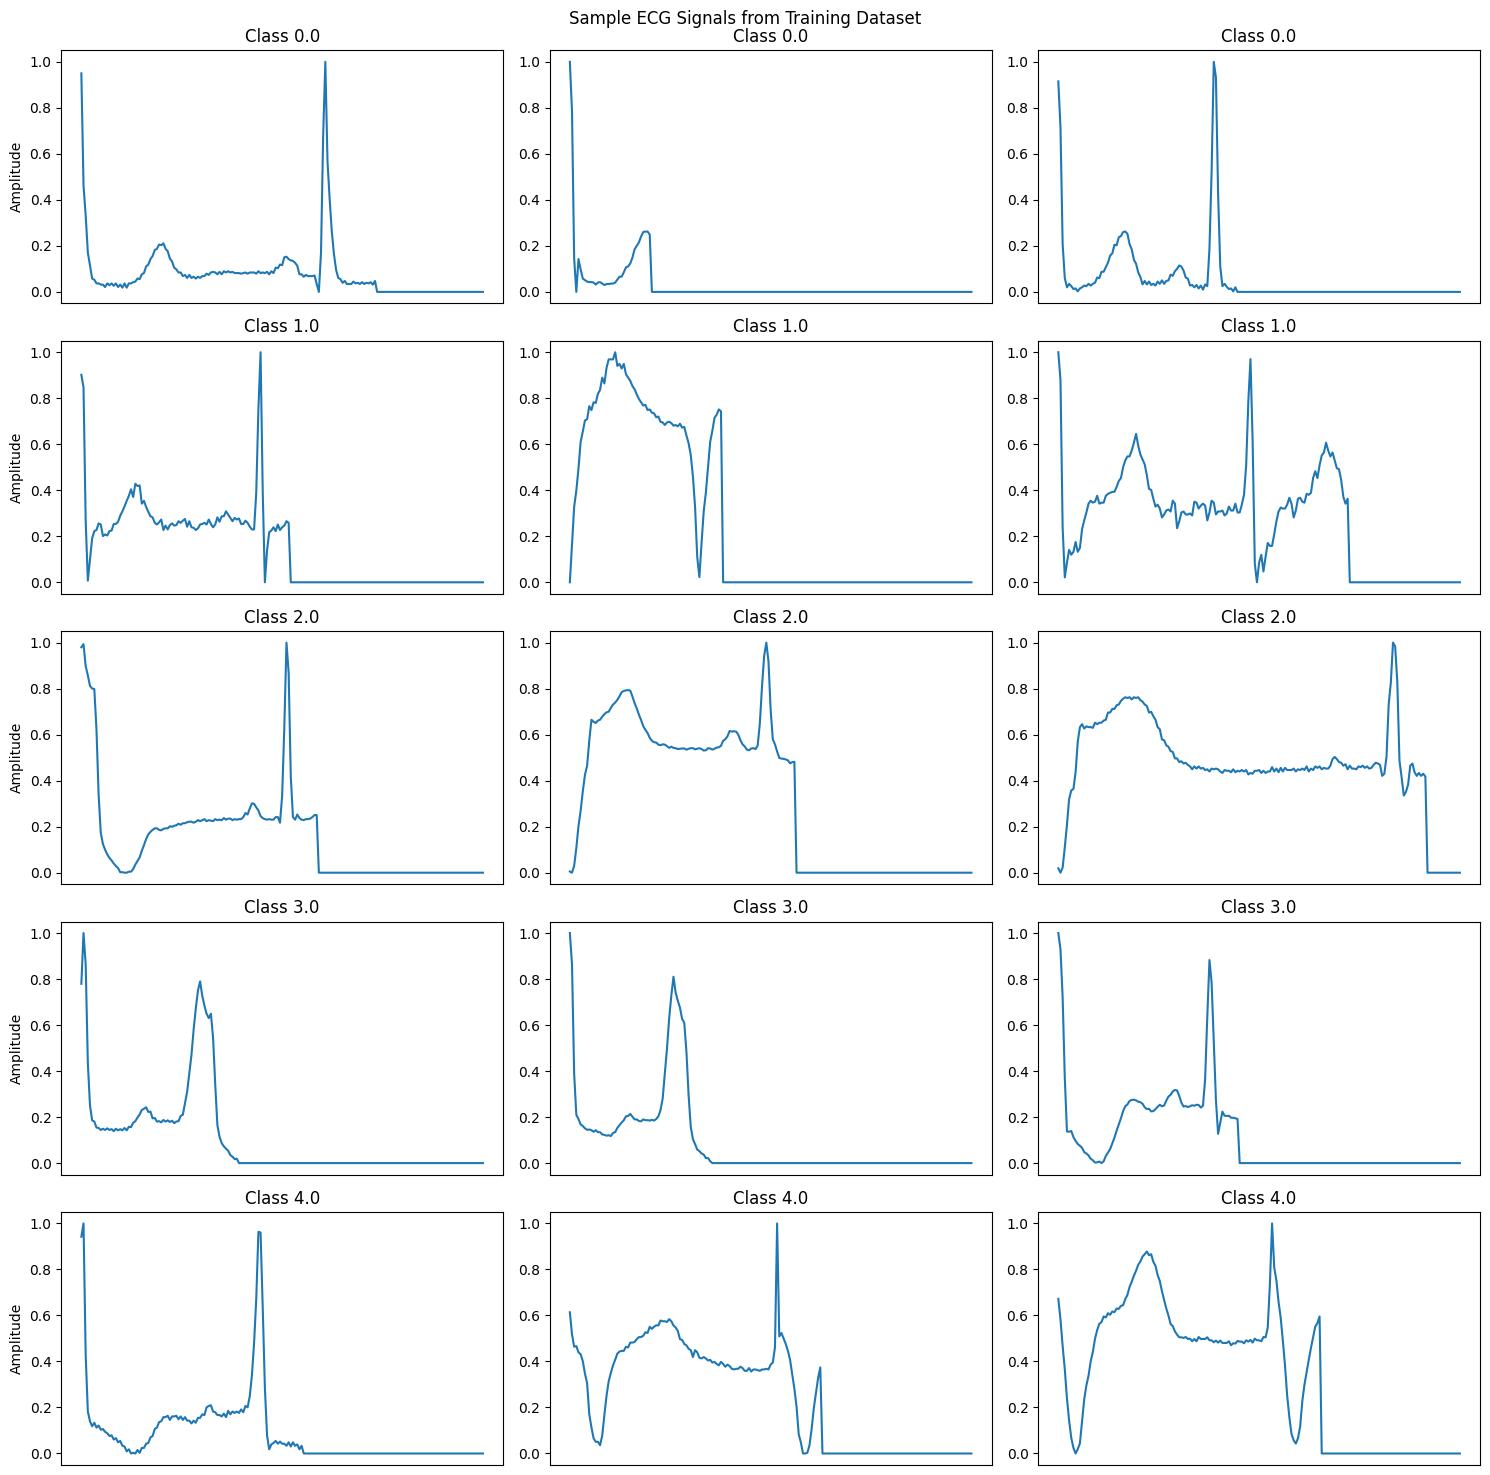


Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [9]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# CNN Model

In [17]:
class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve"""
    def __init__(self, patience=7, min_delta=0, verbose=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            verbose (bool): If True, prints a message for each validation loss improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_epoch = epoch
            if self.verbose:
                print(f'Validation loss improved to {val_loss:.4f}')
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'\nEarly stopping triggered! No improvement for {self.patience} epochs.')
                    print(f'Best validation loss: {self.best_loss:.4f} at epoch {self.best_epoch + 1}')
        else:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0
            if self.verbose:
                print(f'Validation loss improved to {val_loss:.4f}')

class CustomLRScheduler:
    def __init__(self, optimizer, initial_lr, max_lr, warmup_epochs, total_epochs):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def step(self):
        self.current_epoch += 1
        if self.current_epoch <= self.warmup_epochs:
            # Linear warmup
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * (self.current_epoch / self.warmup_epochs)
        else:
            # Cosine annealing
            progress = (self.current_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.initial_lr + 0.5 * (self.max_lr - self.initial_lr) * (1 + np.cos(progress * np.pi))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

class ModelTrainer:
    def __init__(self, model, model_name, device, criterion, config, early_stopping_patience=10):
        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.criterion = criterion
        self.config = config

        # Initialize optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['initial_lr'],
            weight_decay=config['weight_decay']
        )

        # Initialize learning rate scheduler
        self.scheduler = CustomLRScheduler(
            self.optimizer,
            config['initial_lr'],
            config['max_lr'],
            config['warmup_epochs'],
            config['num_epochs']
        )

        # Initialize tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_loss = float('inf')
        
        # Initialize early stopping
        self.early_stopping = EarlyStopping(
            patience=early_stopping_patience,
            min_delta=0.0001,
            verbose=True
        )

        # Create directory for saving models
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.save_dir = os.path.join('models', f"{model_name}_{timestamp}")
        os.makedirs(self.save_dir, exist_ok=True)

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in tqdm(train_loader, desc='Training'):
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

            self.optimizer.zero_grad()

            # Handle different model outputs
            if self.model_name == 'RNN':
                outputs, _ = self.model(batch_X)
            else:
                outputs = self.model(batch_X)

            loss = self.criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                if self.model_name == 'RNN':
                    outputs, _ = self.model(batch_X)
                else:
                    outputs = self.model(batch_X)

                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(val_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, num_epochs):
        """Complete training process with early stopping"""
        print(f"\nStarting training for {self.model_name}...")
        print(f"Early stopping enabled with patience={self.early_stopping.patience}")

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = self.train_epoch(train_loader)

            # Validation phase
            val_loss, val_acc = self.validate(val_loader)

            # Update learning rate
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']

            # Save metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch results
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {current_lr:.6f}')

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_model('best_model.pth')
                print(f'✓ New best model saved! (Val Loss: {val_loss:.4f})')

            # Early stopping check
            self.early_stopping(val_loss, epoch)
            if self.early_stopping.early_stop:
                print(f'\n{"="*60}')
                print(f'Training stopped early at epoch {epoch+1}')
                print(f'Best validation loss: {self.early_stopping.best_loss:.4f}')
                print(f'Best epoch: {self.early_stopping.best_epoch + 1}')
                print(f'{"="*60}\n')
                break

        # Save final model
        self.save_model('final_model.pth')
        
        # Print training summary
        print(f'\n{"="*60}')
        print(f'Training Summary for {self.model_name}')
        print(f'{"="*60}')
        print(f'Total epochs trained: {len(self.train_losses)}')
        print(f'Best validation loss: {self.best_val_loss:.4f}')
        print(f'Final train accuracy: {self.train_accuracies[-1]:.2f}%')
        print(f'Final validation accuracy: {self.val_accuracies[-1]:.2f}%')
        print(f'{"="*60}\n')

    def save_model(self, filename):
        """Save model checkpoint"""
        path = os.path.join(self.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'config': self.config,
            'best_val_loss': self.best_val_loss,
            'early_stopping_info': {
                'stopped_early': self.early_stopping.early_stop,
                'best_epoch': self.early_stopping.best_epoch,
                'patience': self.early_stopping.patience
            }
        }, path)

    def plot_training_history(self):
        """Plot training metrics with early stopping indicator"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        epochs = range(1, len(self.train_losses) + 1)

        # Plot losses
        ax1.plot(epochs, self.train_losses, label='Training Loss', marker='o', markersize=3)
        ax1.plot(epochs, self.val_losses, label='Validation Loss', marker='s', markersize=3)
        
        # Mark best epoch
        best_epoch = self.early_stopping.best_epoch + 1
        if best_epoch <= len(self.val_losses):
            ax1.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
        
        ax1.set_title(f'{self.model_name} - Training History (Loss)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot accuracies
        ax2.plot(epochs, self.train_accuracies, label='Training Accuracy', marker='o', markersize=3)
        ax2.plot(epochs, self.val_accuracies, label='Validation Accuracy', marker='s', markersize=3)
        
        # Mark best epoch
        if best_epoch <= len(self.val_accuracies):
            ax2.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
        
        ax2.set_title(f'{self.model_name} - Training History (Accuracy)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
        plt.show()

    def evaluate(self, test_loader):
        self.model.eval()
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                if self.model_name == 'RNN':
                    outputs, _ = self.model(batch_X)
                else:
                    outputs = self.model(batch_X)

                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(batch_y.cpu().numpy())

        # Print classification report
        print(f"\nClassification Report ({self.model_name}):")
        print(classification_report(true_labels, predictions))

        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix ({self.model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(self.save_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
        plt.show()

# CNN From the Research Paper
https://arxiv.org/pdf/1805.00794

# Hyper parameter tuning 

## Random Search with varying filter size

In [13]:
class FlexibleECG_CNN(nn.Module):

    def __init__(self, input_channels=1, num_classes=5, num_filters=32, 
                 kernel_size=5, num_res_blocks=3, dropout_rate=0.3, 
                 fc_neurons=128, sequence_length=187):
        super(FlexibleECG_CNN, self).__init__()
        
        self.num_res_blocks = num_res_blocks
        
        # Initial convolution
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_channels, num_filters, kernel_size=kernel_size, 
                     stride=1, padding=kernel_size//2),
            nn.BatchNorm1d(num_filters),
            nn.ReLU(),
            nn.Dropout1d(dropout_rate * 0.5),  # Less dropout in early layers
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # Build residual blocks dynamically
        self.res_blocks = nn.ModuleList()
        current_filters = num_filters
        
        for i in range(num_res_blocks):
            # Gradually increase channels
            out_filters = min(num_filters * (2 ** (i // 2)), 256)
            self.res_blocks.append(
                FlexibleResidualBlock(
                    current_filters, 
                    out_filters, 
                    kernel_size=kernel_size,
                    dropout_rate=dropout_rate
                )
            )
            current_filters = out_filters
        
        # Calculate feature size
        self._feature_size = self._get_feature_size(input_channels, sequence_length)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self._feature_size, fc_neurons),
            nn.BatchNorm1d(fc_neurons),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fc_neurons, fc_neurons // 2),
            nn.BatchNorm1d(fc_neurons // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),
            nn.Linear(fc_neurons // 2, num_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _get_feature_size(self, input_channels, sequence_length):
        """Calculate flattened feature size"""
        x = torch.randn(1, input_channels, sequence_length)
        x = self.conv1(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        return x.view(1, -1).size(1)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.BatchNorm1d, nn.LayerNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_channels)
        x = x.transpose(1, 2)  # -> (batch_size, input_channels, sequence_length)
        
        # Initial conv
        x = self.conv1(x)
        
        # Residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Flatten and FC layers
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        
        return x


class FlexibleResidualBlock(nn.Module):
    """Flexible residual block for hyperparameter tuning"""
    def __init__(self, in_channels, out_channels, kernel_size=5, dropout_rate=0.3):
        super(FlexibleResidualBlock, self).__init__()
        
        padding = kernel_size // 2
        
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, 
                     stride=1, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout1d(dropout_rate),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, 
                     stride=1, padding=padding),
            nn.BatchNorm1d(out_channels)
        )
        
        # Skip connection
        self.skip_connection = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm1d(out_channels)
        ) if in_channels != out_channels else nn.Identity()
        
        self.dropout = nn.Dropout1d(dropout_rate)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
    def forward(self, x):
        residual = self.skip_connection(x)
        x = self.conv_block(x)
        x = self.dropout(x + residual)
        x = self.relu(x)
        x = self.pool(x)
        return x


def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, 
                       device, num_epochs=30, patience=10):
    """
    Train and evaluate model during hyperparameter search with early stopping
    Returns best validation accuracy
    """
    model = model.to(device)
    best_val_acc = 0
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        val_acc = 100 * correct / total
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    return best_val_acc


def random_search_cnn(X_train, X_val, X_test, y_train, y_val, y_test, n_iterations=50):
    """
    Perform random search over hyperparameters with early stopping
    """
    # Define hyperparameter ranges
    param_ranges = {
        'num_filters': [16, 32, 64, 128],
        'kernel_size': [3, 5, 7, 9],
        'num_res_blocks': [2, 3, 4, 5],  # Reduced max to avoid memory issues
        'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
        'fc_neurons': [32, 64, 128, 256],
        'learning_rate': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3],
        'batch_size': [32, 64, 128],
        'weight_decay': [0, 1e-5, 1e-4, 1e-3],
    }
    
    results = []
    best_val_acc = 0
    best_params = None
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    print(f"Starting random search with {n_iterations} iterations...")
    print(f"Using device: {device}")
    print(f"Dataset info: {X_train.shape[0]} train samples, {X_val.shape[0]} val samples")
    print(f"Sequence length: {sequence_length}, Classes: {num_classes}\n")
    
    for iteration in range(n_iterations):
        # Randomly sample hyperparameters
        params = {
            key: random.choice(values) 
            for key, values in param_ranges.items()
        }
        
        print(f"\n{'='*70}")
        print(f"Iteration {iteration+1}/{n_iterations}")
        print(f"Parameters: {params}")
        print(f"{'='*70}")
        
        try:
            # Create model
            model = FlexibleECG_CNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                dropout_rate=params['dropout_rate'],
                fc_neurons=params['fc_neurons'],
                sequence_length=sequence_length
            )
            
            # Create data loaders
            train_loader = DataLoader(
                ECGDataset(X_train, y_train),
                batch_size=params['batch_size'],
                shuffle=True,
                num_workers=0
            )
            val_loader = DataLoader(
                ECGDataset(X_val, y_val),
                batch_size=params['batch_size'],
                num_workers=0
            )
            
            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            # Train with early stopping
            val_acc = train_and_evaluate(
                model, train_loader, val_loader,
                criterion, optimizer, device,
                num_epochs=30,
                patience=10
            )
            
            # Store results
            result = {
                'params': params,
                'val_accuracy': val_acc,
                'iteration': iteration
            }
            results.append(result)
            
            print(f"  ✓ Validation Accuracy: {val_acc:.2f}%")
            
            # Update best
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = params.copy()
                print(f"  🎯 New best validation accuracy: {val_acc:.2f}%")
                
        except Exception as e:
            print(f"  ✗ Error in iteration {iteration}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Sort results by accuracy
    results_sorted = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)
    
    print(f"\n{'='*70}")
    print("RANDOM SEARCH COMPLETE")
    print(f"{'='*70}")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print(f"\nBest parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    print(f"\n{'='*70}")
    print(f"Top 5 configurations:")
    print(f"{'='*70}")
    for i, result in enumerate(results_sorted[:5], 1):
        print(f"\n{i}. Accuracy: {result['val_accuracy']:.2f}%")
        print(f"   Parameters:")
        for key, value in result['params'].items():
            print(f"     {key}: {value}")
    
    return results, best_params



In [ ]:
# Run the random search
results, best_params = random_search_cnn(
    X_train, X_val, X_test, y_train, y_val, y_test,
    n_iterations=50
)

Starting random search with 50 iterations...
Using device: cuda
Dataset info: 117401 train samples, 13045 val samples
Sequence length: 187, Classes: 5


Iteration 1/50
Parameters: {'num_filters': 32, 'kernel_size': 5, 'num_res_blocks': 5, 'dropout_rate': 0.3, 'fc_neurons': 128, 'learning_rate': 1e-05, 'batch_size': 32, 'weight_decay': 0}
  ✓ Validation Accuracy: 79.20%
  🎯 New best validation accuracy: 79.20%

Iteration 2/50
Parameters: {'num_filters': 64, 'kernel_size': 5, 'num_res_blocks': 3, 'dropout_rate': 0.3, 'fc_neurons': 32, 'learning_rate': 0.001, 'batch_size': 128, 'weight_decay': 0.0001}
  ✓ Validation Accuracy: 98.90%
  🎯 New best validation accuracy: 98.90%

Iteration 3/50
Parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 3, 'dropout_rate': 0.2, 'fc_neurons': 64, 'learning_rate': 0.0001, 'batch_size': 128, 'weight_decay': 0}
  ✓ Validation Accuracy: 99.31%
  🎯 New best validation accuracy: 99.31%

Iteration 4/50
Parameters: {'num_filters': 128, 'kernel_s

In [14]:
best_params = {
    'num_filters': 128,
    'kernel_size': 5,
    'num_res_blocks': 2,
    'dropout_rate': 0.2,
    'fc_neurons': 256,
    'learning_rate': 0.001,
    'batch_size': 64,
    'weight_decay': 0
}

print("Training model with best configuration...")
print(f"Parameters: {best_params}\n")

# Create the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_length = X_train.shape[1]
num_classes = len(np.unique(y_train))

best_model = FlexibleECG_CNN(
    input_channels=1,
    num_classes=num_classes,
    num_filters=best_params['num_filters'],
    kernel_size=best_params['kernel_size'],
    num_res_blocks=best_params['num_res_blocks'],
    dropout_rate=best_params['dropout_rate'],
    fc_neurons=best_params['fc_neurons'],
    sequence_length=sequence_length
)

# Create data loaders
train_loader = DataLoader(
    ECGDataset(X_train, y_train),
    batch_size=best_params['batch_size'],
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    ECGDataset(X_val, y_val),
    batch_size=best_params['batch_size'],
    num_workers=0
)

test_loader = DataLoader(
    ECGDataset(X_test, y_test),
    batch_size=best_params['batch_size'],
    num_workers=0
)

# Setup training configuration
config = {
    'initial_lr': best_params['learning_rate'],
    'max_lr': best_params['learning_rate'] * 2,
    'warmup_epochs': 5,
    'num_epochs': 50,
    'weight_decay': best_params['weight_decay']
}

criterion = nn.CrossEntropyLoss()

# Initialize the trainer
trainer = ModelTrainer(
    model=best_model,
    model_name='FlexibleECG_CNN_Best',
    device=device,
    criterion=criterion,
    config=config,
    early_stopping_patience=10
)

# Train the model
trainer.train(train_loader, val_loader, num_epochs=config['num_epochs'])

# Plot training history
trainer.plot_training_history()

# Evaluate on test set
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70 + "\n")
trainer.evaluate(test_loader)

# Save detailed results
print(f"\nModel and results saved to: {trainer.save_dir}")

Training model with best configuration...
Parameters: {'num_filters': 128, 'kernel_size': 5, 'num_res_blocks': 2, 'dropout_rate': 0.2, 'fc_neurons': 256, 'learning_rate': 0.001, 'batch_size': 64, 'weight_decay': 0}



NameError: name 'CustomLRScheduler' is not defined

## Random Search Attempt 2

In [ ]:
class FlexibleECG_CNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=5, num_filters=32, 
                 kernel_size=5, num_res_blocks=3, dropout_rate=0.3, 
                 fc_neurons=128, sequence_length=187, 
                 constant_filters=False): 
        super(FlexibleECG_CNN, self).__init__()
        
        self.num_res_blocks = num_res_blocks
        
        # Initial convolution
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_channels, num_filters, kernel_size=kernel_size, 
                     stride=1, padding=kernel_size//2),
            nn.BatchNorm1d(num_filters),
            nn.ReLU(),
            nn.Dropout1d(dropout_rate * 0.5),  # Less dropout in early layers
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # Build residual blocks dynamically
        self.res_blocks = nn.ModuleList()
        current_filters = num_filters
        
        for i in range(num_res_blocks):
            if constant_filters:
                out_filters = num_filters 
            else:
                out_filters = min(num_filters * (2 ** (i // 2)), 256)  # Scale
            self.res_blocks.append(
                FlexibleResidualBlock(
                    current_filters, 
                    out_filters, 
                    kernel_size=kernel_size,
                    dropout_rate=dropout_rate
                )
            )
            current_filters = out_filters
        
        # Calculate feature size
        self._feature_size = self._get_feature_size(input_channels, sequence_length)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self._feature_size, fc_neurons),
            nn.BatchNorm1d(fc_neurons),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fc_neurons, fc_neurons // 2),
            nn.BatchNorm1d(fc_neurons // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8),
            nn.Linear(fc_neurons // 2, num_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _get_feature_size(self, input_channels, sequence_length):
        """Calculate flattened feature size"""
        x = torch.randn(1, input_channels, sequence_length)
        x = self.conv1(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        return x.view(1, -1).size(1)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.BatchNorm1d, nn.LayerNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_channels)
        x = x.transpose(1, 2)  # -> (batch_size, input_channels, sequence_length)
        
        # Initial conv
        x = self.conv1(x)
        
        # Residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Flatten and FC layers
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        
        return x


class FlexibleResidualBlock(nn.Module):
    """Flexible residual block for hyperparameter tuning"""
    def __init__(self, in_channels, out_channels, kernel_size=5, dropout_rate=0.3):
        super(FlexibleResidualBlock, self).__init__()
        
        padding = kernel_size // 2
        
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, 
                     stride=1, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout1d(dropout_rate),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, 
                     stride=1, padding=padding),
            nn.BatchNorm1d(out_channels)
        )
        
        # Skip connection
        self.skip_connection = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm1d(out_channels)
        ) if in_channels != out_channels else nn.Identity()
        
        self.dropout = nn.Dropout1d(dropout_rate)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
    def forward(self, x):
        residual = self.skip_connection(x)
        x = self.conv_block(x)
        x = self.dropout(x + residual)
        x = self.relu(x)
        x = self.pool(x)
        return x


def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, 
                       device, num_epochs=30, patience=10):
    """
    Train and evaluate model during hyperparameter search with early stopping
    Returns best validation accuracy
    """
    model = model.to(device)
    best_val_acc = 0
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        val_acc = 100 * correct / total
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    return best_val_acc


def random_search_cnn(X_train, X_val, X_test, y_train, y_val, y_test, n_iterations=50):
    """
    Perform random search over hyperparameters with early stopping
    """
    # Define hyperparameter ranges
    param_ranges = {
        'num_filters': [16, 32, 64, 128],
        'kernel_size': [3, 5, 7, 9],
        'num_res_blocks': [2, 3, 4, 5],  # Reduced max to avoid memory issues
        'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
        'fc_neurons': [32, 64, 128, 256],
        'learning_rate': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3],
        'batch_size': [32, 64, 128],
        'weight_decay': [0, 1e-5, 1e-4, 1e-3],
    }
    
    results = []
    best_val_acc = 0
    best_params = None
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    print(f"Starting random search with {n_iterations} iterations...")
    print(f"Using device: {device}")
    print(f"Dataset info: {X_train.shape[0]} train samples, {X_val.shape[0]} val samples")
    print(f"Sequence length: {sequence_length}, Classes: {num_classes}\n")
    
    for iteration in range(n_iterations):
        # Randomly sample hyperparameters
        params = {
            key: random.choice(values) 
            for key, values in param_ranges.items()
        }
        
        print(f"\n{'='*70}")
        print(f"Iteration {iteration+1}/{n_iterations}")
        print(f"Parameters: {params}")
        print(f"{'='*70}")
        
        try:
            # Create model
            model = FlexibleECG_CNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                dropout_rate=params['dropout_rate'],
                fc_neurons=params['fc_neurons'],
                sequence_length=sequence_length
            )
            
            # Create data loaders
            train_loader = DataLoader(
                ECGDataset(X_train, y_train),
                batch_size=params['batch_size'],
                shuffle=True,
                num_workers=0
            )
            val_loader = DataLoader(
                ECGDataset(X_val, y_val),
                batch_size=params['batch_size'],
                num_workers=0
            )
            
            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            # Train with early stopping
            val_acc = train_and_evaluate(
                model, train_loader, val_loader,
                criterion, optimizer, device,
                num_epochs=30,
                patience=10
            )
            
            # Store results
            result = {
                'params': params,
                'val_accuracy': val_acc,
                'iteration': iteration
            }
            results.append(result)
            
            print(f"  ✓ Validation Accuracy: {val_acc:.2f}%")
            
            # Update best
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = params.copy()
                print(f"  🎯 New best validation accuracy: {val_acc:.2f}%")
                
        except Exception as e:
            print(f"  ✗ Error in iteration {iteration}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Sort results by accuracy
    results_sorted = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)
    
    print(f"\n{'='*70}")
    print("RANDOM SEARCH COMPLETE")
    print(f"{'='*70}")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print(f"\nBest parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    print(f"\n{'='*70}")
    print(f"Top 5 configurations:")
    print(f"{'='*70}")
    for i, result in enumerate(results_sorted[:5], 1):
        print(f"\n{i}. Accuracy: {result['val_accuracy']:.2f}%")
        print(f"   Parameters:")
        for key, value in result['params'].items():
            print(f"     {key}: {value}")
    
    return results, best_params

In [ ]:
# Run the random search
results, best_params = random_search_cnn(
    X_train, X_val, X_test, y_train, y_val, y_test,
    n_iterations=50
)

Starting random search with 50 iterations...
Using device: cuda
Dataset info: 117401 train samples, 13045 val samples
Sequence length: 187, Classes: 5


Iteration 1/50
Parameters: {'num_filters': 64, 'kernel_size': 5, 'num_res_blocks': 4, 'dropout_rate': 0.5, 'fc_neurons': 128, 'learning_rate': 0.001, 'batch_size': 128, 'weight_decay': 0.001}
  ✓ Validation Accuracy: 97.55%
  🎯 New best validation accuracy: 97.55%

Iteration 2/50
Parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 2, 'dropout_rate': 0.5, 'fc_neurons': 128, 'learning_rate': 0.0005, 'batch_size': 128, 'weight_decay': 0.0001}
  ✓ Validation Accuracy: 98.77%
  🎯 New best validation accuracy: 98.77%

Iteration 3/50
Parameters: {'num_filters': 128, 'kernel_size': 7, 'num_res_blocks': 3, 'dropout_rate': 0.5, 'fc_neurons': 128, 'learning_rate': 5e-05, 'batch_size': 32, 'weight_decay': 0.0001}
  ✓ Validation Accuracy: 97.25%

Iteration 4/50
Parameters: {'num_filters': 32, 'kernel_size': 9, 'num_res_blocks': 3, 

Training model with best configuration (99.65% validation accuracy)...
Parameters: {'num_filters': 128, 'kernel_size': 3, 'num_res_blocks': 5, 'dropout_rate': 0.1, 'fc_neurons': 128, 'learning_rate': 0.001, 'batch_size': 128, 'weight_decay': 1e-05}


Starting training for FlexibleECG_CNN_Best_99.65...
Early stopping enabled with patience=15


Training: 100%|██████████| 918/918 [00:12<00:00, 74.35it/s]



Epoch [1/50]
Train Loss: 0.2458, Train Acc: 91.34%
Val Loss: 0.0819, Val Acc: 97.29%
Learning Rate: 0.001200
✓ New best model saved! (Val Loss: 0.0819)
Validation loss improved to 0.0819


Training: 100%|██████████| 918/918 [00:12<00:00, 74.44it/s]



Epoch [2/50]
Train Loss: 0.1020, Train Acc: 96.51%
Val Loss: 0.0611, Val Acc: 98.11%
Learning Rate: 0.001400
✓ New best model saved! (Val Loss: 0.0611)
Validation loss improved to 0.0611


Training: 100%|██████████| 918/918 [00:12<00:00, 74.05it/s]



Epoch [3/50]
Train Loss: 0.0760, Train Acc: 97.41%
Val Loss: 0.0472, Val Acc: 98.40%
Learning Rate: 0.001600
✓ New best model saved! (Val Loss: 0.0472)
Validation loss improved to 0.0472


Training: 100%|██████████| 918/918 [00:12<00:00, 73.88it/s]



Epoch [4/50]
Train Loss: 0.0609, Train Acc: 97.90%
Val Loss: 0.0430, Val Acc: 98.72%
Learning Rate: 0.001800
✓ New best model saved! (Val Loss: 0.0430)
Validation loss improved to 0.0430


Training: 100%|██████████| 918/918 [00:12<00:00, 72.82it/s]



Epoch [5/50]
Train Loss: 0.0520, Train Acc: 98.20%
Val Loss: 0.0382, Val Acc: 98.77%
Learning Rate: 0.002000
✓ New best model saved! (Val Loss: 0.0382)
Validation loss improved to 0.0382


Training: 100%|██████████| 918/918 [00:12<00:00, 73.26it/s]



Epoch [6/50]
Train Loss: 0.0476, Train Acc: 98.37%
Val Loss: 0.0380, Val Acc: 98.76%
Learning Rate: 0.001999
✓ New best model saved! (Val Loss: 0.0380)
Validation loss improved to 0.0380


Training: 100%|██████████| 918/918 [00:12<00:00, 72.27it/s]



Epoch [7/50]
Train Loss: 0.0415, Train Acc: 98.61%
Val Loss: 0.0356, Val Acc: 98.82%
Learning Rate: 0.001995
✓ New best model saved! (Val Loss: 0.0356)
Validation loss improved to 0.0356


Training: 100%|██████████| 918/918 [00:12<00:00, 73.86it/s]



Epoch [8/50]
Train Loss: 0.0369, Train Acc: 98.78%
Val Loss: 0.0289, Val Acc: 99.08%
Learning Rate: 0.001989
✓ New best model saved! (Val Loss: 0.0289)
Validation loss improved to 0.0289


Training: 100%|██████████| 918/918 [00:12<00:00, 75.80it/s]



Epoch [9/50]
Train Loss: 0.0311, Train Acc: 98.95%
Val Loss: 0.0264, Val Acc: 99.29%
Learning Rate: 0.001981
✓ New best model saved! (Val Loss: 0.0264)
Validation loss improved to 0.0264


Training: 100%|██████████| 918/918 [00:12<00:00, 75.84it/s]



Epoch [10/50]
Train Loss: 0.0298, Train Acc: 99.00%
Val Loss: 0.0221, Val Acc: 99.31%
Learning Rate: 0.001970
✓ New best model saved! (Val Loss: 0.0221)
Validation loss improved to 0.0221


Training: 100%|██████████| 918/918 [00:12<00:00, 75.71it/s]



Epoch [11/50]
Train Loss: 0.0266, Train Acc: 99.13%
Val Loss: 0.0213, Val Acc: 99.36%
Learning Rate: 0.001957
✓ New best model saved! (Val Loss: 0.0213)
Validation loss improved to 0.0213


Training: 100%|██████████| 918/918 [00:12<00:00, 74.92it/s]



Epoch [12/50]
Train Loss: 0.0233, Train Acc: 99.22%
Val Loss: 0.0283, Val Acc: 99.17%
Learning Rate: 0.001941
EarlyStopping counter: 1 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.47it/s]



Epoch [13/50]
Train Loss: 0.0217, Train Acc: 99.27%
Val Loss: 0.0212, Val Acc: 99.33%
Learning Rate: 0.001924
✓ New best model saved! (Val Loss: 0.0212)
Validation loss improved to 0.0212


Training: 100%|██████████| 918/918 [00:12<00:00, 75.72it/s]



Epoch [14/50]
Train Loss: 0.0198, Train Acc: 99.33%
Val Loss: 0.0212, Val Acc: 99.39%
Learning Rate: 0.001905
EarlyStopping counter: 1 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.63it/s]



Epoch [15/50]
Train Loss: 0.0195, Train Acc: 99.37%
Val Loss: 0.0177, Val Acc: 99.57%
Learning Rate: 0.001883
✓ New best model saved! (Val Loss: 0.0177)
Validation loss improved to 0.0177


Training: 100%|██████████| 918/918 [00:12<00:00, 75.77it/s]



Epoch [16/50]
Train Loss: 0.0168, Train Acc: 99.44%
Val Loss: 0.0270, Val Acc: 99.26%
Learning Rate: 0.001860
EarlyStopping counter: 1 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.68it/s]



Epoch [17/50]
Train Loss: 0.0165, Train Acc: 99.46%
Val Loss: 0.0200, Val Acc: 99.48%
Learning Rate: 0.001835
EarlyStopping counter: 2 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.76it/s]



Epoch [18/50]
Train Loss: 0.0137, Train Acc: 99.54%
Val Loss: 0.0198, Val Acc: 99.52%
Learning Rate: 0.001808
EarlyStopping counter: 3 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.79it/s]



Epoch [19/50]
Train Loss: 0.0142, Train Acc: 99.55%
Val Loss: 0.0173, Val Acc: 99.62%
Learning Rate: 0.001780
✓ New best model saved! (Val Loss: 0.0173)
Validation loss improved to 0.0173


Training: 100%|██████████| 918/918 [00:12<00:00, 75.64it/s]



Epoch [20/50]
Train Loss: 0.0122, Train Acc: 99.60%
Val Loss: 0.0203, Val Acc: 99.52%
Learning Rate: 0.001750
EarlyStopping counter: 1 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.75it/s]



Epoch [21/50]
Train Loss: 0.0113, Train Acc: 99.62%
Val Loss: 0.0185, Val Acc: 99.55%
Learning Rate: 0.001719
EarlyStopping counter: 2 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 72.95it/s]



Epoch [22/50]
Train Loss: 0.0117, Train Acc: 99.62%
Val Loss: 0.0207, Val Acc: 99.52%
Learning Rate: 0.001687
EarlyStopping counter: 3 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.16it/s]



Epoch [23/50]
Train Loss: 0.0104, Train Acc: 99.66%
Val Loss: 0.0214, Val Acc: 99.58%
Learning Rate: 0.001655
EarlyStopping counter: 4 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.55it/s]



Epoch [24/50]
Train Loss: 0.0096, Train Acc: 99.67%
Val Loss: 0.0179, Val Acc: 99.61%
Learning Rate: 0.001621
EarlyStopping counter: 5 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 73.58it/s]



Epoch [25/50]
Train Loss: 0.0086, Train Acc: 99.72%
Val Loss: 0.0204, Val Acc: 99.50%
Learning Rate: 0.001587
EarlyStopping counter: 6 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.15it/s]



Epoch [26/50]
Train Loss: 0.0076, Train Acc: 99.75%
Val Loss: 0.0185, Val Acc: 99.63%
Learning Rate: 0.001552
EarlyStopping counter: 7 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.40it/s]



Epoch [27/50]
Train Loss: 0.0080, Train Acc: 99.76%
Val Loss: 0.0188, Val Acc: 99.65%
Learning Rate: 0.001517
EarlyStopping counter: 8 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 74.29it/s]



Epoch [28/50]
Train Loss: 0.0083, Train Acc: 99.74%
Val Loss: 0.0182, Val Acc: 99.60%
Learning Rate: 0.001483
EarlyStopping counter: 9 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 74.84it/s]



Epoch [29/50]
Train Loss: 0.0066, Train Acc: 99.77%
Val Loss: 0.0171, Val Acc: 99.65%
Learning Rate: 0.001448
✓ New best model saved! (Val Loss: 0.0171)
Validation loss improved to 0.0171


Training: 100%|██████████| 918/918 [00:12<00:00, 75.25it/s]



Epoch [30/50]
Train Loss: 0.0064, Train Acc: 99.79%
Val Loss: 0.0181, Val Acc: 99.65%
Learning Rate: 0.001413
EarlyStopping counter: 1 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.39it/s]



Epoch [31/50]
Train Loss: 0.0060, Train Acc: 99.81%
Val Loss: 0.0238, Val Acc: 99.48%
Learning Rate: 0.001379
EarlyStopping counter: 2 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.49it/s]



Epoch [32/50]
Train Loss: 0.0060, Train Acc: 99.80%
Val Loss: 0.0148, Val Acc: 99.67%
Learning Rate: 0.001345
✓ New best model saved! (Val Loss: 0.0148)
Validation loss improved to 0.0148


Training: 100%|██████████| 918/918 [00:12<00:00, 74.22it/s]



Epoch [33/50]
Train Loss: 0.0055, Train Acc: 99.83%
Val Loss: 0.0179, Val Acc: 99.66%
Learning Rate: 0.001313
EarlyStopping counter: 1 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 74.60it/s]



Epoch [34/50]
Train Loss: 0.0047, Train Acc: 99.85%
Val Loss: 0.0147, Val Acc: 99.74%
Learning Rate: 0.001281
✓ New best model saved! (Val Loss: 0.0147)
Validation loss improved to 0.0147


Training: 100%|██████████| 918/918 [00:12<00:00, 75.22it/s]



Epoch [35/50]
Train Loss: 0.0054, Train Acc: 99.82%
Val Loss: 0.0185, Val Acc: 99.67%
Learning Rate: 0.001250
EarlyStopping counter: 1 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.40it/s]



Epoch [36/50]
Train Loss: 0.0042, Train Acc: 99.87%
Val Loss: 0.0183, Val Acc: 99.70%
Learning Rate: 0.001220
EarlyStopping counter: 2 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.45it/s]



Epoch [37/50]
Train Loss: 0.0039, Train Acc: 99.87%
Val Loss: 0.0182, Val Acc: 99.65%
Learning Rate: 0.001192
EarlyStopping counter: 3 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.28it/s]



Epoch [38/50]
Train Loss: 0.0049, Train Acc: 99.84%
Val Loss: 0.0163, Val Acc: 99.78%
Learning Rate: 0.001165
EarlyStopping counter: 4 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.50it/s]



Epoch [39/50]
Train Loss: 0.0036, Train Acc: 99.89%
Val Loss: 0.0174, Val Acc: 99.67%
Learning Rate: 0.001140
EarlyStopping counter: 5 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.42it/s]



Epoch [40/50]
Train Loss: 0.0038, Train Acc: 99.89%
Val Loss: 0.0182, Val Acc: 99.69%
Learning Rate: 0.001117
EarlyStopping counter: 6 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.38it/s]



Epoch [41/50]
Train Loss: 0.0039, Train Acc: 99.87%
Val Loss: 0.0164, Val Acc: 99.76%
Learning Rate: 0.001095
EarlyStopping counter: 7 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.47it/s]



Epoch [42/50]
Train Loss: 0.0033, Train Acc: 99.88%
Val Loss: 0.0180, Val Acc: 99.73%
Learning Rate: 0.001076
EarlyStopping counter: 8 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.60it/s]



Epoch [43/50]
Train Loss: 0.0028, Train Acc: 99.90%
Val Loss: 0.0189, Val Acc: 99.72%
Learning Rate: 0.001059
EarlyStopping counter: 9 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.49it/s]



Epoch [44/50]
Train Loss: 0.0034, Train Acc: 99.89%
Val Loss: 0.0204, Val Acc: 99.67%
Learning Rate: 0.001043
EarlyStopping counter: 10 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 75.47it/s]



Epoch [45/50]
Train Loss: 0.0030, Train Acc: 99.90%
Val Loss: 0.0186, Val Acc: 99.72%
Learning Rate: 0.001030
EarlyStopping counter: 11 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 74.63it/s]



Epoch [46/50]
Train Loss: 0.0026, Train Acc: 99.91%
Val Loss: 0.0175, Val Acc: 99.75%
Learning Rate: 0.001019
EarlyStopping counter: 12 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 73.29it/s]



Epoch [47/50]
Train Loss: 0.0032, Train Acc: 99.90%
Val Loss: 0.0184, Val Acc: 99.70%
Learning Rate: 0.001011
EarlyStopping counter: 13 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 73.30it/s]



Epoch [48/50]
Train Loss: 0.0024, Train Acc: 99.92%
Val Loss: 0.0193, Val Acc: 99.69%
Learning Rate: 0.001005
EarlyStopping counter: 14 out of 15


Training: 100%|██████████| 918/918 [00:12<00:00, 74.81it/s]



Epoch [49/50]
Train Loss: 0.0022, Train Acc: 99.93%
Val Loss: 0.0184, Val Acc: 99.75%
Learning Rate: 0.001001
EarlyStopping counter: 15 out of 15

Early stopping triggered! No improvement for 15 epochs.
Best validation loss: 0.0147 at epoch 34

Training stopped early at epoch 49
Best validation loss: 0.0147
Best epoch: 34


Training Summary for FlexibleECG_CNN_Best_99.65
Total epochs trained: 49
Best validation loss: 0.0147
Final train accuracy: 99.93%
Final validation accuracy: 99.75%



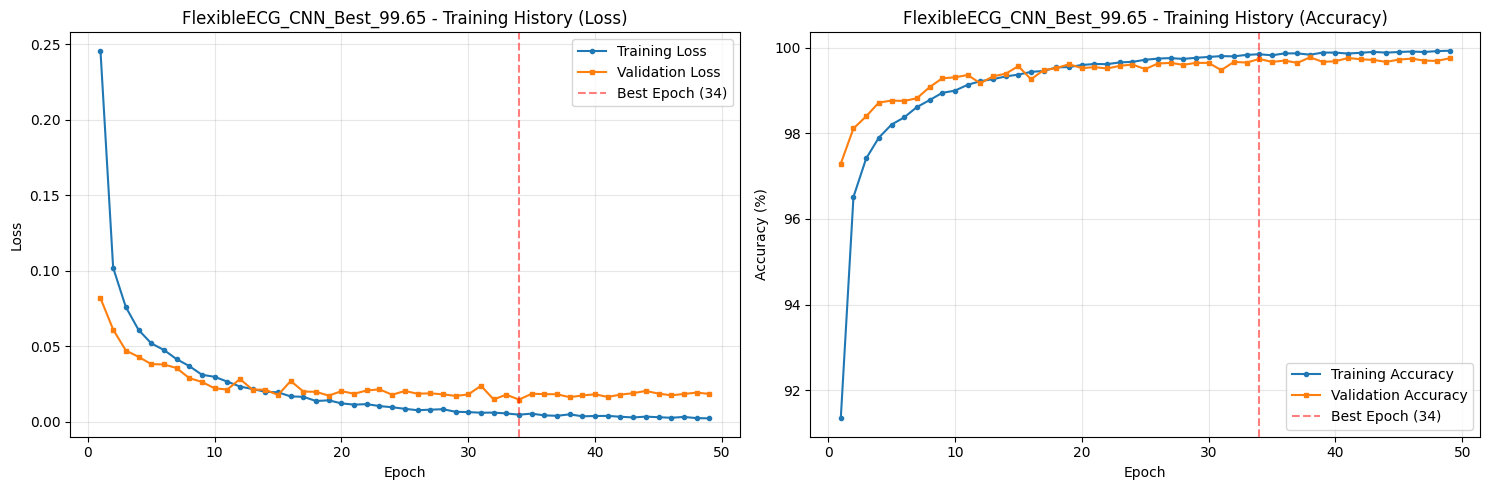


EVALUATING ON TEST SET



Testing: 100%|██████████| 172/172 [00:00<00:00, 261.12it/s]



Classification Report (FlexibleECG_CNN_Best_99.65):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.85      0.86      0.85       556
           2       0.98      0.97      0.97      1448
           3       0.74      0.84      0.79       162
           4       1.00      1.00      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.91      0.93      0.92     21892
weighted avg       0.99      0.99      0.99     21892



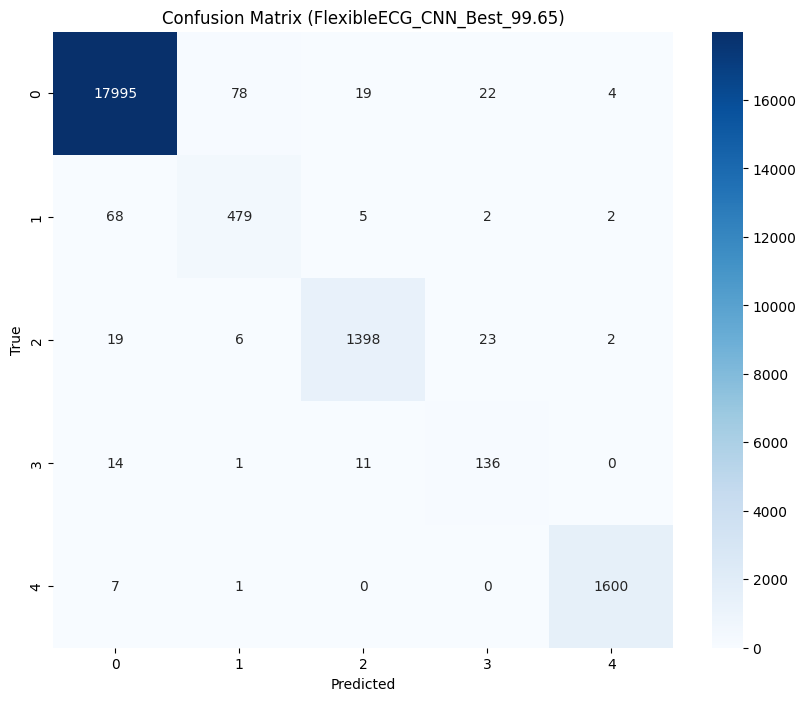


Model and results saved to: models\FlexibleECG_CNN_Best_99.65_20251103_173342

TOP 5 CONFIGURATIONS FROM RANDOM SEARCH
1. Val Acc: 99.65% - 128 filters, kernel 3, 5 res blocks, 0.1 dropout, 128 FC, lr 0.001 ← TRAINED
2. Val Acc: 99.60% - 128 filters, kernel 5, 5 res blocks, 0.2 dropout, 64 FC, lr 0.001 
3. Val Acc: 99.55% - 128 filters, kernel 7, 2 res blocks, 0.2 dropout, 64 FC, lr 0.001 
4. Val Acc: 99.46% - 64 filters, kernel 5, 4 res blocks, 0.2 dropout, 64 FC, lr 0.001 
5. Val Acc: 99.33% - 32 filters, kernel 9, 3 res blocks, 0.2 dropout, 256 FC, lr 0.001 



In [114]:
# Train the best model configuration and evaluate it

# Best parameters from the second random search
best_params = {
    'num_filters': 128,
    'kernel_size': 3,
    'num_res_blocks': 5,
    'dropout_rate': 0.1,
    'fc_neurons': 128,
    'learning_rate': 0.001,
    'batch_size': 128,
    'weight_decay': 1e-05
}

print("Training model with best configuration (99.65% validation accuracy)...")
print(f"Parameters: {best_params}\n")

# Create the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_length = X_train.shape[1]
num_classes = len(np.unique(y_train))

best_model = FlexibleECG_CNN(
    input_channels=1,
    num_classes=num_classes,
    num_filters=best_params['num_filters'],
    kernel_size=best_params['kernel_size'],
    num_res_blocks=best_params['num_res_blocks'],
    dropout_rate=best_params['dropout_rate'],
    fc_neurons=best_params['fc_neurons'],
    sequence_length=sequence_length,
    constant_filters=False  # Default behavior - filters scale with depth
)

# Create data loaders
train_loader = DataLoader(
    ECGDataset(X_train, y_train),
    batch_size=best_params['batch_size'],
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    ECGDataset(X_val, y_val),
    batch_size=best_params['batch_size'],
    num_workers=0
)

test_loader = DataLoader(
    ECGDataset(X_test, y_test),
    batch_size=best_params['batch_size'],
    num_workers=0
)

# Setup training configuration
config = {
    'initial_lr': best_params['learning_rate'],
    'max_lr': best_params['learning_rate'] * 2,
    'warmup_epochs': 5,
    'num_epochs': 50,
    'weight_decay': best_params['weight_decay']
}

criterion = nn.CrossEntropyLoss()

# Initialize the trainer
trainer = ModelTrainer(
    model=best_model,
    model_name='FlexibleECG_CNN_Best_99.65',
    device=device,
    criterion=criterion,
    config=config,
    early_stopping_patience=15
)

# Train the model
trainer.train(train_loader, val_loader, num_epochs=config['num_epochs'])

# Plot training history
trainer.plot_training_history()

# Evaluate on test set
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70 + "\n")
trainer.evaluate(test_loader)

# Save detailed results
print(f"\nModel and results saved to: {trainer.save_dir}")

# Print comparison with top configurations
print("\n" + "="*70)
print("TOP 5 CONFIGURATIONS FROM RANDOM SEARCH")
print("="*70)
top_configs = [
    (99.65, "128 filters, kernel 3, 5 res blocks, 0.1 dropout, 128 FC, lr 0.001"),
    (99.60, "128 filters, kernel 5, 5 res blocks, 0.2 dropout, 64 FC, lr 0.001"),
    (99.55, "128 filters, kernel 7, 2 res blocks, 0.2 dropout, 64 FC, lr 0.001"),
    (99.46, "64 filters, kernel 5, 4 res blocks, 0.2 dropout, 64 FC, lr 0.001"),
    (99.33, "32 filters, kernel 9, 3 res blocks, 0.2 dropout, 256 FC, lr 0.001")
]

for i, (acc, desc) in enumerate(top_configs, 1):
    status = "← TRAINED" if i == 1 else ""
    print(f"{i}. Val Acc: {acc:.2f}% - {desc} {status}")

print("\n" + "="*70)

# Final Architecture

In [15]:
import math

In [14]:
def calculate_output_length(input_length, kernel_size, stride, padding=0):
    """Calculate output length after conv/pool operation"""
    return math.floor((input_length + 2 * padding - kernel_size) / stride + 1)


def validate_architecture(sequence_length, num_res_blocks, pool_size, pool_stride):
    """
    Validate that the architecture won't cause sequence length to become 0
    
    Returns:
        (valid, final_length, error_message)
    """
    current_length = sequence_length
    
    for i in range(num_res_blocks):
        # After maxpool
        current_length = calculate_output_length(current_length, pool_size, pool_stride)
        
        if current_length <= 0:
            return False, 0, f"Sequence becomes 0 at block {i+1}/{num_res_blocks}"
    
    if current_length < 1:
        return False, current_length, "Final sequence length too small"
    
    return True, current_length, "Valid"


class FinalResidualBlock(nn.Module):
    """
    Final residual block with validation
    """
    def __init__(self, in_channels, out_channels, kernel_size=5, pool_size=5, pool_stride=2):
        super(FinalResidualBlock, self).__init__()
        
        # First conv layer
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        
        # Second conv layer
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # Skip connection
        self.skip_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else nn.Identity()
        
        # ReLU after adding skip connection
        self.relu2 = nn.ReLU()
        
        # Max pooling
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride)
        
    def forward(self, x):
        # Store input for skip connection
        identity = self.skip_connection(x)
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add skip connection
        out = out + identity
        out = self.relu2(out)
        
        # Max pooling
        out = self.pool(out)
        
        return out


class FlexibleFinalCNN(nn.Module):
    """
    Flexible final CNN with validation to prevent pooling errors
    """
    def __init__(self, input_channels=1, num_classes=5, num_filters=32, 
                 kernel_size=5, num_res_blocks=5, pool_size=5, pool_stride=2,
                 fc_neurons=32, dropout_rate=0.3, sequence_length=187,
                 constant_filters=True):
        super(FlexibleFinalCNN, self).__init__()
        
        # Validate architecture before building
        valid, final_length, msg = validate_architecture(
            sequence_length, num_res_blocks, pool_size, pool_stride
        )
        
        if not valid:
            raise ValueError(
                f"Invalid architecture: {msg}\n"
                f"Input length: {sequence_length}, Blocks: {num_res_blocks}, "
                f"Pool: {pool_size}/{pool_stride}\n"
                f"Try: fewer blocks, smaller pool_size, or larger pool_stride"
            )
        
        self.num_res_blocks = num_res_blocks
        self.constant_filters = constant_filters
        
        # Build residual blocks dynamically
        self.res_blocks = nn.ModuleList()
        current_filters = input_channels
        
        for i in range(num_res_blocks):
            if constant_filters:
                out_filters = num_filters
            else:
                out_filters = min(num_filters * (2 ** (i // 2)), 256)
            
            self.res_blocks.append(
                FinalResidualBlock(
                    current_filters, 
                    out_filters,
                    kernel_size=kernel_size,
                    pool_size=pool_size,
                    pool_stride=pool_stride
                )
            )
            current_filters = out_filters
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Calculate flattened feature size
        self._feature_size = self._get_feature_size(input_channels, sequence_length)
        
        # Fully connected layers (paper-style: fc_neurons → fc_neurons → output)
        self.fc1 = nn.Linear(self._feature_size, fc_neurons)
        self.relu_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(fc_neurons, fc_neurons)
        self.relu_fc2 = nn.ReLU()
        
        # Output layer
        self.fc3 = nn.Linear(fc_neurons, num_classes)
        
        # Initialize weights
        self._init_weights()
    
    def _get_feature_size(self, input_channels, sequence_length):
        """Calculate the size of flattened features after all residual blocks"""
        x = torch.randn(1, input_channels, sequence_length)
        
        for res_block in self.res_blocks:
            x = res_block(x)
        
        return x.view(1, -1).size(1)
    
    def _init_weights(self):
        """Initialize weights using He initialization for ReLU"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """Forward pass"""
        # Reshape for 1D convolution
        x = x.transpose(1, 2)
        
        # Residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x
    
    def count_parameters(self):
        """Count total and trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"\nModel Parameters:")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        return total_params, trainable_params

In [15]:
def train_and_evaluate_final(model, train_loader, val_loader, criterion, optimizer, 
                                   device, num_epochs=30, patience=10):
    """Train and evaluate model with early stopping"""
    model = model.to(device)
    best_val_acc = 0
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        val_acc = 100 * correct / total
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    return best_val_acc


def random_search_final(X_train, X_val, X_test, y_train, y_val, y_test, 
                              n_iterations=50, constant_filters=True):
    """
    Random search with validation to skip invalid architectures
    """
    import random
    from torch.utils.data import DataLoader
    import torch.optim as optim
    
    # Define hyperparameter ranges with safer defaults
    param_ranges = {
        'num_filters': [16, 32, 64, 128],
        'kernel_size': [3, 5, 7, 9],
        'num_res_blocks': [2, 3, 4, 5],
        'pool_size': [2, 3, 5],      # Safer range
        'pool_stride': [2],           # Keep stride at 2 for safety
        'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
        'fc_neurons': [32, 64, 128, 256],
        'learning_rate': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3],
        'batch_size': [32, 64, 128],
        'weight_decay': [0, 1e-5, 1e-4, 1e-3],
    }
    
    results = []
    best_val_acc = 0
    best_params = None
    skipped = 0
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    filter_mode = "CONSTANT" if constant_filters else "SCALING"
    
    print("="*70)
    print(f"RANDOM SEARCH: FINAL ARCHITECTURE ({filter_mode} FILTERS)")
    print("="*70)
    print(f"Iterations: {n_iterations}")
    print(f"Device: {device}")
    print(f"Dataset: {X_train.shape[0]} train, {X_val.shape[0]} val samples")
    print(f"Sequence length: {sequence_length}, Classes: {num_classes}")
    print(f"Architecture: Final architecture with validation")
    print(f"Filter mode: {filter_mode}")
    print("="*70 + "\n")
    
    iteration = 0
    attempts = 0
    max_attempts = n_iterations * 3  # Allow some retries for invalid configs
    
    while iteration < n_iterations and attempts < max_attempts:
        attempts += 1
        
        # Randomly sample hyperparameters
        params = {
            key: random.choice(values) 
            for key, values in param_ranges.items()
        }
        
        # Validate architecture before creating model
        valid, final_len, msg = validate_architecture(
            sequence_length, 
            params['num_res_blocks'], 
            params['pool_size'], 
            params['pool_stride']
        )
        
        if not valid:
            skipped += 1
            print(f"⊘ Skipped invalid config: {msg} "
                  f"(blocks={params['num_res_blocks']}, pool={params['pool_size']}/{params['pool_stride']})")
            continue
        
        iteration += 1
        
        print(f"\n{'='*70}")
        print(f"Iteration {iteration}/{n_iterations} (Skipped: {skipped})")
        print(f"Filters: {params['num_filters']} ({filter_mode.lower()}) × {params['num_res_blocks']} blocks")
        print(f"Kernel: {params['kernel_size']}, Pool: {params['pool_size']}/{params['pool_stride']} → final_len={final_len}")
        print(f"Dropout: {params['dropout_rate']}, FC: {params['fc_neurons']} → {params['fc_neurons']} → {num_classes}")
        print(f"LR: {params['learning_rate']}, Batch: {params['batch_size']}, WD: {params['weight_decay']}")
        print(f"{'='*70}")
        
        try:
            # Create model
            model = FlexibleFinalCNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                pool_size=params['pool_size'],
                pool_stride=params['pool_stride'],
                fc_neurons=params['fc_neurons'],
                dropout_rate=params['dropout_rate'],
                sequence_length=sequence_length,
                constant_filters=constant_filters
            )
            
            # Create data loaders
            train_loader = DataLoader(
                ECGDataset(X_train, y_train),
                batch_size=params['batch_size'],
                shuffle=True,
                num_workers=0
            )
            val_loader = DataLoader(
                ECGDataset(X_val, y_val),
                batch_size=params['batch_size'],
                num_workers=0
            )
            
            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            # Train with early stopping
            val_acc = train_and_evaluate_final(
                model, train_loader, val_loader,
                criterion, optimizer, device,
                num_epochs=30,
                patience=10
            )
            
            # Store results
            result = {
                'params': params,
                'val_accuracy': val_acc,
                'iteration': iteration,
                'constant_filters': constant_filters,
                'architecture': 'final',
                'final_sequence_length': final_len
            }
            results.append(result)
            
            print(f"  ✓ Validation Accuracy: {val_acc:.2f}%")
            
            # Update best
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = params.copy()
                print(f"  🎯 NEW BEST: {val_acc:.2f}%")
                
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Sort results by accuracy
    results_sorted = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)
    
    # Print final results
    print(f"\n{'='*70}")
    print(f"RANDOM SEARCH COMPLETE - FINAL ARCHITECTURE ({filter_mode} FILTERS)")
    print(f"{'='*70}")
    print(f"Completed iterations: {len(results)}/{n_iterations}")
    print(f"Skipped invalid configs: {skipped}")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print(f"\nBest parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    print(f"\n{'='*70}")
    print(f"Top 10 Configurations:")
    print(f"{'='*70}")
    for i, result in enumerate(results_sorted[:10], 1):
        p = result['params']
        print(f"\n{i}. Val Acc: {result['val_accuracy']:.2f}%")
        print(f"   {p['num_filters']} filters × {p['num_res_blocks']} blocks ({filter_mode.lower()})")
        print(f"   Kernel={p['kernel_size']}, Pool={p['pool_size']}/{p['pool_stride']}")
        print(f"   Dropout={p['dropout_rate']}, FC={p['fc_neurons']}→{p['fc_neurons']}→{num_classes}")
        print(f"   LR={p['learning_rate']}, Batch={p['batch_size']}, WD={p['weight_decay']}")
    
    print("="*70)
    
    return results, best_params, results_sorted

In [134]:
results_final, best_params_final, sorted_final = random_search_final(
    X_train, X_val, X_test, y_train, y_val, y_test,
    n_iterations=50,
    constant_filters=True
)

RANDOM SEARCH: FINAL ARCHITECTURE (CONSTANT FILTERS)
Iterations: 50
Device: cuda
Dataset: 117401 train, 13045 val samples
Sequence length: 187, Classes: 5
Architecture: Final architecture with validation
Filter mode: CONSTANT


Iteration 1/50 (Skipped: 0)
Filters: 16 (constant) × 3 blocks
Kernel: 5, Pool: 5/2 → final_len=20
Dropout: 0.3, FC: 64 → 64 → 5
LR: 0.001, Batch: 64, WD: 0.0001
  ✓ Validation Accuracy: 98.55%
  🎯 NEW BEST: 98.55%

Iteration 2/50 (Skipped: 0)
Filters: 16 (constant) × 5 blocks
Kernel: 7, Pool: 5/2 → final_len=2
Dropout: 0.1, FC: 64 → 64 → 5
LR: 5e-05, Batch: 64, WD: 1e-05
  ✓ Validation Accuracy: 97.84%

Iteration 3/50 (Skipped: 0)
Filters: 128 (constant) × 4 blocks
Kernel: 3, Pool: 2/2 → final_len=11
Dropout: 0.4, FC: 256 → 256 → 5
LR: 0.0001, Batch: 32, WD: 1e-05
  ✓ Validation Accuracy: 99.21%
  🎯 NEW BEST: 99.21%

Iteration 4/50 (Skipped: 0)
Filters: 128 (constant) × 2 blocks
Kernel: 3, Pool: 5/2 → final_len=44
Dropout: 0.4, FC: 64 → 64 → 5
LR: 0.0005, Batch:

Training model with best configuration with fixed filter (99.62% validation accuracy)...
Parameters: {'num_filters': 128, 'kernel_size': 5, 'num_res_blocks': 5, 'pool_size': 3, 'pool_stride': 2, 'dropout_rate': 0.2, 'fc_neurons': 32, 'learning_rate': 0.0005, 'batch_size': 64, 'weight_decay': 1e-05}


Starting training for FlexibleFinalCNN_Best_99.62...
Early stopping enabled with patience=10


Training: 100%|██████████| 1835/1835 [00:22<00:00, 82.48it/s]



Epoch [1/50]
Train Loss: 1.9607, Train Acc: 33.64%
Val Loss: 1.5608, Val Acc: 33.34%
Learning Rate: 0.000600
✓ New best model saved! (Val Loss: 1.5608)
Validation loss improved to 1.5608


Training: 100%|██████████| 1835/1835 [00:20<00:00, 89.63it/s]



Epoch [2/50]
Train Loss: 1.5569, Train Acc: 34.21%
Val Loss: 1.4914, Val Acc: 37.46%
Learning Rate: 0.000700
✓ New best model saved! (Val Loss: 1.4914)
Validation loss improved to 1.4914


Training: 100%|██████████| 1835/1835 [00:20<00:00, 90.24it/s]



Epoch [3/50]
Train Loss: 1.4975, Train Acc: 37.63%
Val Loss: 1.4569, Val Acc: 39.01%
Learning Rate: 0.000800
✓ New best model saved! (Val Loss: 1.4569)
Validation loss improved to 1.4569


Training: 100%|██████████| 1835/1835 [00:20<00:00, 90.37it/s]



Epoch [4/50]
Train Loss: 1.3885, Train Acc: 42.84%
Val Loss: 0.9361, Val Acc: 61.81%
Learning Rate: 0.000900
✓ New best model saved! (Val Loss: 0.9361)
Validation loss improved to 0.9361


Training: 100%|██████████| 1835/1835 [00:20<00:00, 87.93it/s]



Epoch [5/50]
Train Loss: 0.9664, Train Acc: 59.53%
Val Loss: 0.8222, Val Acc: 63.33%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.8222)
Validation loss improved to 0.8222


Training: 100%|██████████| 1835/1835 [00:20<00:00, 89.14it/s]



Epoch [6/50]
Train Loss: 0.8603, Train Acc: 62.63%
Val Loss: 0.8875, Val Acc: 61.70%
Learning Rate: 0.000999
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1835/1835 [00:20<00:00, 89.21it/s]



Epoch [7/50]
Train Loss: 0.7837, Train Acc: 64.58%
Val Loss: 0.4816, Val Acc: 80.53%
Learning Rate: 0.000998
✓ New best model saved! (Val Loss: 0.4816)
Validation loss improved to 0.4816


Training: 100%|██████████| 1835/1835 [00:20<00:00, 89.49it/s]



Epoch [8/50]
Train Loss: 0.4995, Train Acc: 81.74%
Val Loss: 0.2234, Val Acc: 95.02%
Learning Rate: 0.000995
✓ New best model saved! (Val Loss: 0.2234)
Validation loss improved to 0.2234


Training: 100%|██████████| 1835/1835 [00:21<00:00, 87.37it/s]



Epoch [9/50]
Train Loss: 0.3446, Train Acc: 89.62%
Val Loss: 0.1542, Val Acc: 96.77%
Learning Rate: 0.000990
✓ New best model saved! (Val Loss: 0.1542)
Validation loss improved to 0.1542


Training: 100%|██████████| 1835/1835 [00:20<00:00, 90.36it/s]



Epoch [10/50]
Train Loss: 0.2311, Train Acc: 93.87%
Val Loss: 0.1196, Val Acc: 97.13%
Learning Rate: 0.000985
✓ New best model saved! (Val Loss: 0.1196)
Validation loss improved to 0.1196


Training: 100%|██████████| 1835/1835 [00:18<00:00, 98.12it/s] 



Epoch [11/50]
Train Loss: 0.1722, Train Acc: 95.77%
Val Loss: 0.1031, Val Acc: 97.54%
Learning Rate: 0.000978
✓ New best model saved! (Val Loss: 0.1031)
Validation loss improved to 0.1031


Training: 100%|██████████| 1835/1835 [00:18<00:00, 98.36it/s] 



Epoch [12/50]
Train Loss: 0.1429, Train Acc: 96.58%
Val Loss: 0.0740, Val Acc: 98.28%
Learning Rate: 0.000971
✓ New best model saved! (Val Loss: 0.0740)
Validation loss improved to 0.0740


Training: 100%|██████████| 1835/1835 [00:18<00:00, 98.54it/s]



Epoch [13/50]
Train Loss: 0.1225, Train Acc: 97.15%
Val Loss: 0.0569, Val Acc: 98.69%
Learning Rate: 0.000962
✓ New best model saved! (Val Loss: 0.0569)
Validation loss improved to 0.0569


Training: 100%|██████████| 1835/1835 [00:18<00:00, 98.46it/s] 



Epoch [14/50]
Train Loss: 0.0941, Train Acc: 97.81%
Val Loss: 0.0729, Val Acc: 98.05%
Learning Rate: 0.000952
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1835/1835 [00:18<00:00, 98.35it/s] 



Epoch [15/50]
Train Loss: 0.0755, Train Acc: 98.20%
Val Loss: 0.0433, Val Acc: 98.90%
Learning Rate: 0.000942
✓ New best model saved! (Val Loss: 0.0433)
Validation loss improved to 0.0433


Training: 100%|██████████| 1835/1835 [00:18<00:00, 98.22it/s] 



Epoch [16/50]
Train Loss: 0.0607, Train Acc: 98.55%
Val Loss: 0.0354, Val Acc: 99.12%
Learning Rate: 0.000930
✓ New best model saved! (Val Loss: 0.0354)
Validation loss improved to 0.0354


Training: 100%|██████████| 1835/1835 [00:18<00:00, 97.92it/s]



Epoch [17/50]
Train Loss: 0.0514, Train Acc: 98.77%
Val Loss: 0.0570, Val Acc: 98.73%
Learning Rate: 0.000917
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1835/1835 [00:18<00:00, 98.22it/s] 



Epoch [18/50]
Train Loss: 0.0442, Train Acc: 98.97%
Val Loss: 0.0361, Val Acc: 99.26%
Learning Rate: 0.000904
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 1835/1835 [00:18<00:00, 98.08it/s] 



Epoch [19/50]
Train Loss: 0.0353, Train Acc: 99.18%
Val Loss: 0.0672, Val Acc: 98.86%
Learning Rate: 0.000890
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 1835/1835 [00:18<00:00, 98.08it/s] 



Epoch [20/50]
Train Loss: 0.0347, Train Acc: 99.21%
Val Loss: 0.0378, Val Acc: 99.23%
Learning Rate: 0.000875
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 1835/1835 [00:18<00:00, 98.19it/s] 



Epoch [21/50]
Train Loss: 0.0290, Train Acc: 99.33%
Val Loss: 0.0413, Val Acc: 99.27%
Learning Rate: 0.000860
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 94.68it/s]



Epoch [22/50]
Train Loss: 0.0280, Train Acc: 99.39%
Val Loss: 0.0385, Val Acc: 99.27%
Learning Rate: 0.000844
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 94.24it/s]



Epoch [23/50]
Train Loss: 0.0245, Train Acc: 99.47%
Val Loss: 0.0359, Val Acc: 99.43%
Learning Rate: 0.000827
EarlyStopping counter: 7 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 94.05it/s]



Epoch [24/50]
Train Loss: 0.0243, Train Acc: 99.52%
Val Loss: 0.0394, Val Acc: 99.39%
Learning Rate: 0.000810
EarlyStopping counter: 8 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.84it/s]



Epoch [25/50]
Train Loss: 0.0201, Train Acc: 99.56%
Val Loss: 0.0337, Val Acc: 99.47%
Learning Rate: 0.000793
✓ New best model saved! (Val Loss: 0.0337)
Validation loss improved to 0.0337


Training: 100%|██████████| 1835/1835 [00:19<00:00, 94.01it/s]



Epoch [26/50]
Train Loss: 0.0184, Train Acc: 99.58%
Val Loss: 0.0413, Val Acc: 99.43%
Learning Rate: 0.000776
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.60it/s]



Epoch [27/50]
Train Loss: 0.0168, Train Acc: 99.64%
Val Loss: 0.0451, Val Acc: 99.36%
Learning Rate: 0.000759
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.44it/s]



Epoch [28/50]
Train Loss: 0.0169, Train Acc: 99.62%
Val Loss: 0.0331, Val Acc: 99.56%
Learning Rate: 0.000741
✓ New best model saved! (Val Loss: 0.0331)
Validation loss improved to 0.0331


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.99it/s]



Epoch [29/50]
Train Loss: 0.0138, Train Acc: 99.72%
Val Loss: 0.0399, Val Acc: 99.42%
Learning Rate: 0.000724
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.91it/s]



Epoch [30/50]
Train Loss: 0.0146, Train Acc: 99.71%
Val Loss: 0.0281, Val Acc: 99.59%
Learning Rate: 0.000707
✓ New best model saved! (Val Loss: 0.0281)
Validation loss improved to 0.0281


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.30it/s]



Epoch [31/50]
Train Loss: 0.0129, Train Acc: 99.72%
Val Loss: 0.0489, Val Acc: 99.43%
Learning Rate: 0.000690
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 94.23it/s]



Epoch [32/50]
Train Loss: 0.0117, Train Acc: 99.76%
Val Loss: 0.0349, Val Acc: 99.63%
Learning Rate: 0.000673
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.85it/s]



Epoch [33/50]
Train Loss: 0.0101, Train Acc: 99.78%
Val Loss: 0.0341, Val Acc: 99.51%
Learning Rate: 0.000656
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.91it/s]



Epoch [34/50]
Train Loss: 0.0112, Train Acc: 99.78%
Val Loss: 0.0410, Val Acc: 99.54%
Learning Rate: 0.000640
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.96it/s]



Epoch [35/50]
Train Loss: 0.0094, Train Acc: 99.80%
Val Loss: 0.0408, Val Acc: 99.64%
Learning Rate: 0.000625
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.96it/s]



Epoch [36/50]
Train Loss: 0.0087, Train Acc: 99.84%
Val Loss: 0.0392, Val Acc: 99.56%
Learning Rate: 0.000610
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.89it/s]



Epoch [37/50]
Train Loss: 0.0096, Train Acc: 99.82%
Val Loss: 0.0363, Val Acc: 99.52%
Learning Rate: 0.000596
EarlyStopping counter: 7 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.94it/s]



Epoch [38/50]
Train Loss: 0.0076, Train Acc: 99.85%
Val Loss: 0.0531, Val Acc: 99.59%
Learning Rate: 0.000583
EarlyStopping counter: 8 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.90it/s]



Epoch [39/50]
Train Loss: 0.0086, Train Acc: 99.85%
Val Loss: 0.0574, Val Acc: 99.39%
Learning Rate: 0.000570
EarlyStopping counter: 9 out of 10


Training: 100%|██████████| 1835/1835 [00:19<00:00, 93.85it/s]



Epoch [40/50]
Train Loss: 0.0070, Train Acc: 99.88%
Val Loss: 0.0427, Val Acc: 99.66%
Learning Rate: 0.000558
EarlyStopping counter: 10 out of 10

Early stopping triggered! No improvement for 10 epochs.
Best validation loss: 0.0281 at epoch 30

Training stopped early at epoch 40
Best validation loss: 0.0281
Best epoch: 30


Training Summary for FlexibleFinalCNN_Best_99.62
Total epochs trained: 40
Best validation loss: 0.0281
Final train accuracy: 99.88%
Final validation accuracy: 99.66%



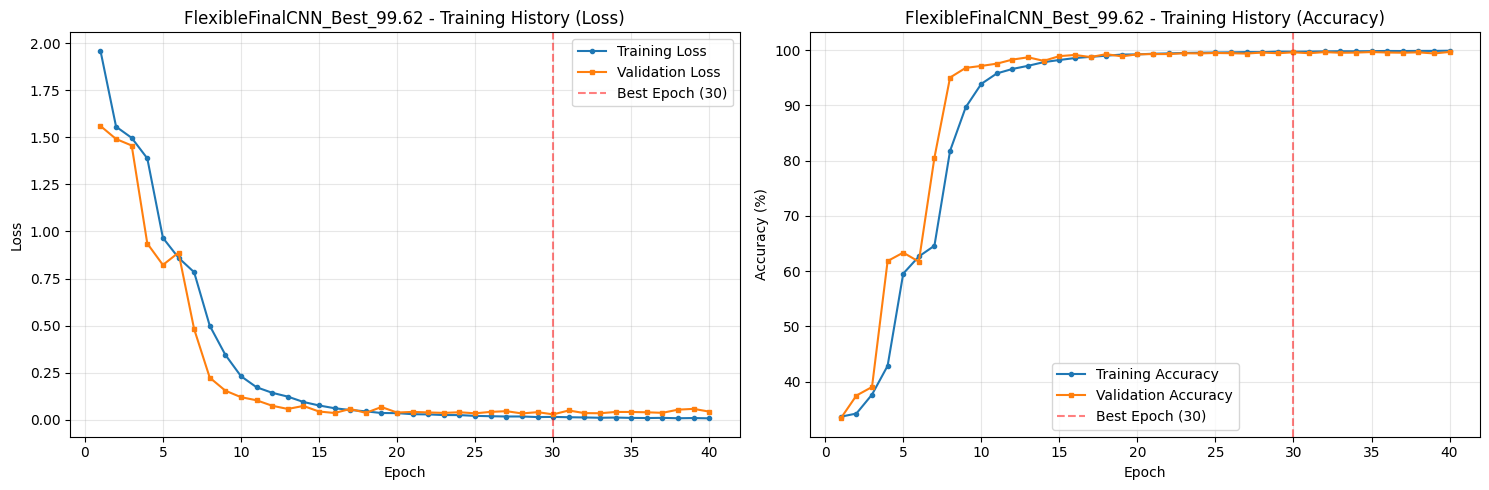


EVALUATING ON TEST SET



Testing: 100%|██████████| 343/343 [00:01<00:00, 261.02it/s]



Classification Report (FlexibleFinalCNN_Best_99.62):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.83      0.86      0.84       556
           2       0.96      0.97      0.96      1448
           3       0.80      0.85      0.82       162
           4       1.00      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.92      0.93      0.92     21892
weighted avg       0.99      0.99      0.99     21892



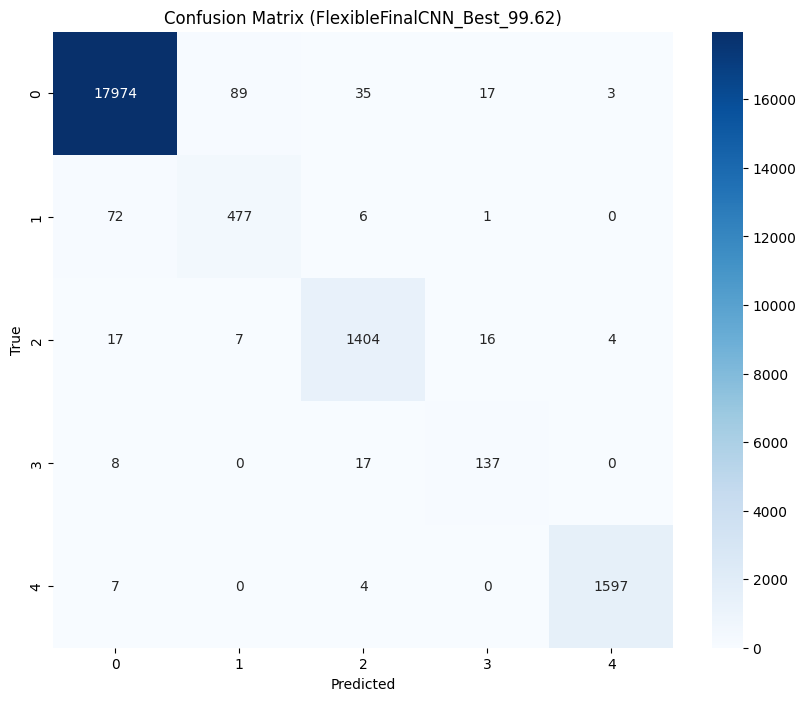


Model and results saved to: models\FlexibleFinalCNN_Best_99.62_20251104_012201


In [ ]:
best_params = {
    'num_filters': 128,
    'kernel_size': 5,
    'num_res_blocks': 5,
    'pool_size': 3,           
    'pool_stride': 2,         
    'dropout_rate': 0.2,
    'fc_neurons': 32,
    'learning_rate': 0.0005,  
    'batch_size': 64,
    'weight_decay': 1e-5
}

print("Training model with best configuration with fixed filter (99.62% validation accuracy)...")
print(f"Parameters: {best_params}\n")

# Create the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_length = X_train.shape[1]
num_classes = len(np.unique(y_train))

best_model = FlexibleFinalCNN(
    input_channels=1,
    num_classes=num_classes,
    num_filters=best_params['num_filters'],
    kernel_size=best_params['kernel_size'],
    num_res_blocks=best_params['num_res_blocks'],
    pool_size=best_params['pool_size'],        
    pool_stride=best_params['pool_stride'],   
    fc_neurons=best_params['fc_neurons'],
    dropout_rate=best_params['dropout_rate'],
    sequence_length=sequence_length,
    constant_filters=True  
)

# Create data loaders
train_loader = DataLoader(
    ECGDataset(X_train, y_train),
    batch_size=best_params['batch_size'],
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    ECGDataset(X_val, y_val),
    batch_size=best_params['batch_size'],
    num_workers=0
)

test_loader = DataLoader(
    ECGDataset(X_test, y_test),
    batch_size=best_params['batch_size'],
    num_workers=0
)

# Setup training configuration
config = {
    'initial_lr': best_params['learning_rate'],
    'max_lr': best_params['learning_rate'] * 2,
    'warmup_epochs': 5,
    'num_epochs': 50,
    'weight_decay': best_params['weight_decay']
}

criterion = nn.CrossEntropyLoss()

# Initialize the trainer
trainer = ModelTrainer(
    model=best_model,
    model_name='FlexibleFinalCNN',  
    device=device,
    criterion=criterion,
    config=config,
    early_stopping_patience=10
)

# Train the model
trainer.train(train_loader, val_loader, num_epochs=config['num_epochs'])

# Plot training history
trainer.plot_training_history()

# Evaluate on test set
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70 + "\n")
trainer.evaluate(test_loader)

# Save detailed results
print(f"\nModel and results saved to: {trainer.save_dir}")

# Squeeze and Excitation Attention CNN

In [12]:
import torch
import torch.nn as nn
import math

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        
        # Squeeze: Global average pooling
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        
        # Excitation: Two FC layers with bottleneck
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch_size, channels, _ = x.size()
        
        # Squeeze: [B, C, T] → [B, C, 1] → [B, C]
        y = self.squeeze(x).view(batch_size, channels)
        
        # Excitation: [B, C] → [B, C/r] → [B, C]
        y = self.excitation(y).view(batch_size, channels, 1)
        
        # Scale: Multiply attention weights with input
        return x * y.expand_as(x)


class SEResidualBlock(nn.Module):
    """
    Residual Block with SE Attention
    """
    def __init__(self, in_channels, out_channels, kernel_size=5, 
                 pool_size=5, pool_stride=2, reduction=16):
        super(SEResidualBlock, self).__init__()
        
        # First conv layer
        self.conv1 = nn.Conv1d(in_channels, out_channels, 
                               kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        
        # Second conv layer
        self.conv2 = nn.Conv1d(out_channels, out_channels, 
                               kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # SE Attention Block
        self.se = SEBlock(out_channels, reduction=reduction)
        
        # Skip connection
        self.skip_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else nn.Identity()
        
        # ReLU after adding skip connection
        self.relu2 = nn.ReLU()
        
        # Max pooling
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride)
        
    def forward(self, x):
        # Store input for skip connection
        identity = self.skip_connection(x)
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Apply SE attention
        out = self.se(out)
        
        # Add skip connection
        out = out + identity
        out = self.relu2(out)
        
        # Max pooling
        out = self.pool(out)
        
        return out


class FlexibleSECNN(nn.Module):

    def __init__(self, input_channels=1, num_classes=5, num_filters=32, 
                 kernel_size=5, num_res_blocks=5, pool_size=5, pool_stride=2,
                 fc_neurons=32, dropout_rate=0.3, sequence_length=187,
                 constant_filters=True, se_reduction=16):
        super(FlexibleSECNN, self).__init__()
        
        # Validate architecture
        valid, final_length, msg = validate_architecture(
            sequence_length, num_res_blocks, pool_size, pool_stride
        )
        
        if not valid:
            raise ValueError(
                f"Invalid architecture: {msg}\n"
                f"Input length: {sequence_length}, Blocks: {num_res_blocks}, "
                f"Pool: {pool_size}/{pool_stride}\n"
                f"Try: fewer blocks, smaller pool_size, or larger pool_stride"
            )
        
        self.num_res_blocks = num_res_blocks
        self.constant_filters = constant_filters
        
        # Build SE residual blocks
        self.res_blocks = nn.ModuleList()
        current_filters = input_channels
        
        for i in range(num_res_blocks):
            if constant_filters:
                out_filters = num_filters
            else:
                out_filters = min(num_filters * (2 ** (i // 2)), 256)
            
            self.res_blocks.append(
                SEResidualBlock(
                    current_filters, 
                    out_filters,
                    kernel_size=kernel_size,
                    pool_size=pool_size,
                    pool_stride=pool_stride,
                    reduction=se_reduction
                )
            )
            current_filters = out_filters
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Calculate flattened feature size
        self._feature_size = self._get_feature_size(input_channels, sequence_length)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self._feature_size, fc_neurons)
        self.relu_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(fc_neurons, fc_neurons)
        self.relu_fc2 = nn.ReLU()
        
        # Output layer
        self.fc3 = nn.Linear(fc_neurons, num_classes)
        
        # Initialize weights
        self._init_weights()
    
    def _get_feature_size(self, input_channels, sequence_length):
        """Calculate the size of flattened features"""
        x = torch.randn(1, input_channels, sequence_length)
        for res_block in self.res_blocks:
            x = res_block(x)
        return x.view(1, -1).size(1)
    
    def _init_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # ⭐ FIX
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # ⭐ FIX
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """Forward pass"""
        # Reshape for 1D convolution
        x = x.transpose(1, 2)
        
        # SE Residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x
    
    def count_parameters(self):
        """Count total and trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"\nModel Parameters:")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        return total_params, trainable_params

Model created: FlexibleSECNN

Model Parameters:
Total parameters: 769,893
Trainable parameters: 769,893

Starting training for FlexibleSECNN...
Early stopping enabled with patience=10


Training: 100%|██████████| 1232/1232 [00:15<00:00, 79.46it/s]



Epoch [1/50]
Train Loss: 0.6587, Train Acc: 88.68%
Val Loss: 0.2008, Val Acc: 94.46%
Learning Rate: 0.000600
✓ New best model saved! (Val Loss: 0.2008)
Validation loss improved to 0.2008


Training: 100%|██████████| 1232/1232 [00:15<00:00, 81.68it/s]



Epoch [2/50]
Train Loss: 0.2346, Train Acc: 93.89%
Val Loss: 0.1557, Val Acc: 94.66%
Learning Rate: 0.000700
✓ New best model saved! (Val Loss: 0.1557)
Validation loss improved to 0.1557


Training: 100%|██████████| 1232/1232 [00:15<00:00, 81.30it/s]



Epoch [3/50]
Train Loss: 0.1706, Train Acc: 95.18%
Val Loss: 0.1197, Val Acc: 97.03%
Learning Rate: 0.000800
✓ New best model saved! (Val Loss: 0.1197)
Validation loss improved to 0.1197


Training: 100%|██████████| 1232/1232 [00:15<00:00, 81.47it/s]



Epoch [4/50]
Train Loss: 0.1436, Train Acc: 96.31%
Val Loss: 0.1161, Val Acc: 97.02%
Learning Rate: 0.000900
✓ New best model saved! (Val Loss: 0.1161)
Validation loss improved to 0.1161


Training: 100%|██████████| 1232/1232 [00:16<00:00, 74.58it/s]



Epoch [5/50]
Train Loss: 0.1223, Train Acc: 96.87%
Val Loss: 0.0877, Val Acc: 97.58%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.0877)
Validation loss improved to 0.0877


Training: 100%|██████████| 1232/1232 [00:17<00:00, 69.31it/s]



Epoch [6/50]
Train Loss: 0.1090, Train Acc: 97.21%
Val Loss: 0.0887, Val Acc: 97.59%
Learning Rate: 0.000999
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.69it/s]



Epoch [7/50]
Train Loss: 0.0937, Train Acc: 97.66%
Val Loss: 0.0751, Val Acc: 98.17%
Learning Rate: 0.000998
✓ New best model saved! (Val Loss: 0.0751)
Validation loss improved to 0.0751


Training: 100%|██████████| 1232/1232 [00:17<00:00, 71.61it/s]



Epoch [8/50]
Train Loss: 0.0791, Train Acc: 97.98%
Val Loss: 0.0713, Val Acc: 98.31%
Learning Rate: 0.000995
✓ New best model saved! (Val Loss: 0.0713)
Validation loss improved to 0.0713


Training: 100%|██████████| 1232/1232 [00:15<00:00, 81.28it/s]



Epoch [9/50]
Train Loss: 0.0717, Train Acc: 98.17%
Val Loss: 0.0759, Val Acc: 98.44%
Learning Rate: 0.000990
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1232/1232 [00:16<00:00, 72.65it/s]



Epoch [10/50]
Train Loss: 0.0631, Train Acc: 98.37%
Val Loss: 0.0680, Val Acc: 98.25%
Learning Rate: 0.000985
✓ New best model saved! (Val Loss: 0.0680)
Validation loss improved to 0.0680


Training: 100%|██████████| 1232/1232 [00:20<00:00, 58.98it/s]



Epoch [11/50]
Train Loss: 0.0556, Train Acc: 98.53%
Val Loss: 0.0605, Val Acc: 98.50%
Learning Rate: 0.000978
✓ New best model saved! (Val Loss: 0.0605)
Validation loss improved to 0.0605


Training: 100%|██████████| 1232/1232 [00:20<00:00, 60.29it/s]



Epoch [12/50]
Train Loss: 0.0517, Train Acc: 98.66%
Val Loss: 0.0628, Val Acc: 98.54%
Learning Rate: 0.000971
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1232/1232 [00:19<00:00, 64.46it/s]



Epoch [13/50]
Train Loss: 0.0459, Train Acc: 98.74%
Val Loss: 0.0517, Val Acc: 98.66%
Learning Rate: 0.000962
✓ New best model saved! (Val Loss: 0.0517)
Validation loss improved to 0.0517


Training: 100%|██████████| 1232/1232 [00:18<00:00, 66.33it/s]



Epoch [14/50]
Train Loss: 0.0419, Train Acc: 98.82%
Val Loss: 0.0597, Val Acc: 98.52%
Learning Rate: 0.000952
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1232/1232 [00:18<00:00, 67.35it/s]



Epoch [15/50]
Train Loss: 0.0424, Train Acc: 98.89%
Val Loss: 0.0536, Val Acc: 98.85%
Learning Rate: 0.000942
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 1232/1232 [00:23<00:00, 53.05it/s]



Epoch [16/50]
Train Loss: 0.0358, Train Acc: 99.08%
Val Loss: 0.0685, Val Acc: 98.56%
Learning Rate: 0.000930
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 1232/1232 [00:24<00:00, 50.80it/s]



Epoch [17/50]
Train Loss: 0.0371, Train Acc: 99.05%
Val Loss: 0.0529, Val Acc: 98.79%
Learning Rate: 0.000917
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 1232/1232 [00:22<00:00, 53.57it/s]



Epoch [18/50]
Train Loss: 0.0318, Train Acc: 99.12%
Val Loss: 0.0501, Val Acc: 98.86%
Learning Rate: 0.000904
✓ New best model saved! (Val Loss: 0.0501)
Validation loss improved to 0.0501


Training: 100%|██████████| 1232/1232 [00:24<00:00, 49.87it/s]



Epoch [19/50]
Train Loss: 0.0292, Train Acc: 99.20%
Val Loss: 0.0628, Val Acc: 98.82%
Learning Rate: 0.000890
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1232/1232 [00:22<00:00, 53.93it/s]



Epoch [20/50]
Train Loss: 0.0250, Train Acc: 99.31%
Val Loss: 0.0634, Val Acc: 98.86%
Learning Rate: 0.000875
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 1232/1232 [00:22<00:00, 54.78it/s]



Epoch [21/50]
Train Loss: 0.0268, Train Acc: 99.25%
Val Loss: 0.0619, Val Acc: 98.70%
Learning Rate: 0.000860
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 1232/1232 [00:22<00:00, 54.59it/s]



Epoch [22/50]
Train Loss: 0.0220, Train Acc: 99.37%
Val Loss: 0.0831, Val Acc: 98.65%
Learning Rate: 0.000844
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 1232/1232 [00:22<00:00, 54.55it/s]



Epoch [23/50]
Train Loss: 0.0213, Train Acc: 99.40%
Val Loss: 0.0670, Val Acc: 98.82%
Learning Rate: 0.000827
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 1232/1232 [00:22<00:00, 54.62it/s]



Epoch [24/50]
Train Loss: 0.0195, Train Acc: 99.49%
Val Loss: 0.0705, Val Acc: 98.79%
Learning Rate: 0.000810
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 1232/1232 [00:22<00:00, 53.57it/s]



Epoch [25/50]
Train Loss: 0.0190, Train Acc: 99.46%
Val Loss: 0.0744, Val Acc: 98.56%
Learning Rate: 0.000793
EarlyStopping counter: 7 out of 10


Training: 100%|██████████| 1232/1232 [00:23<00:00, 53.09it/s]



Epoch [26/50]
Train Loss: 0.0174, Train Acc: 99.48%
Val Loss: 0.0686, Val Acc: 98.93%
Learning Rate: 0.000776
EarlyStopping counter: 8 out of 10


Training: 100%|██████████| 1232/1232 [00:23<00:00, 51.38it/s]



Epoch [27/50]
Train Loss: 0.0167, Train Acc: 99.50%
Val Loss: 0.0998, Val Acc: 98.86%
Learning Rate: 0.000759
EarlyStopping counter: 9 out of 10


Training: 100%|██████████| 1232/1232 [00:22<00:00, 54.11it/s]



Epoch [28/50]
Train Loss: 0.0159, Train Acc: 99.55%
Val Loss: 0.0852, Val Acc: 98.74%
Learning Rate: 0.000741
EarlyStopping counter: 10 out of 10

Early stopping triggered! No improvement for 10 epochs.
Best validation loss: 0.0501 at epoch 18

Training stopped early at epoch 28
Best validation loss: 0.0501
Best epoch: 18


Training Summary for FlexibleSECNN
Total epochs trained: 28
Best validation loss: 0.0501
Final train accuracy: 99.55%
Final validation accuracy: 98.74%



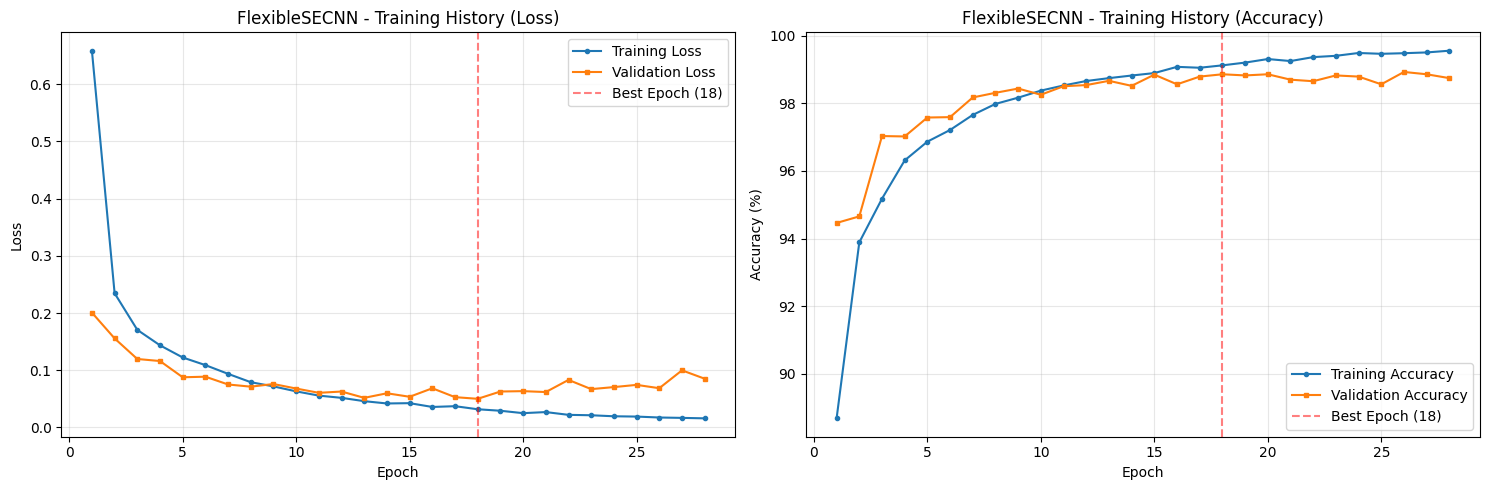

Testing: 100%|██████████| 343/343 [00:02<00:00, 152.96it/s]



Classification Report (FlexibleSECNN):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.93      0.78      0.85       556
           2       0.97      0.96      0.96      1448
           3       0.76      0.86      0.81       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.93      0.92      0.92     21892
weighted avg       0.99      0.99      0.99     21892



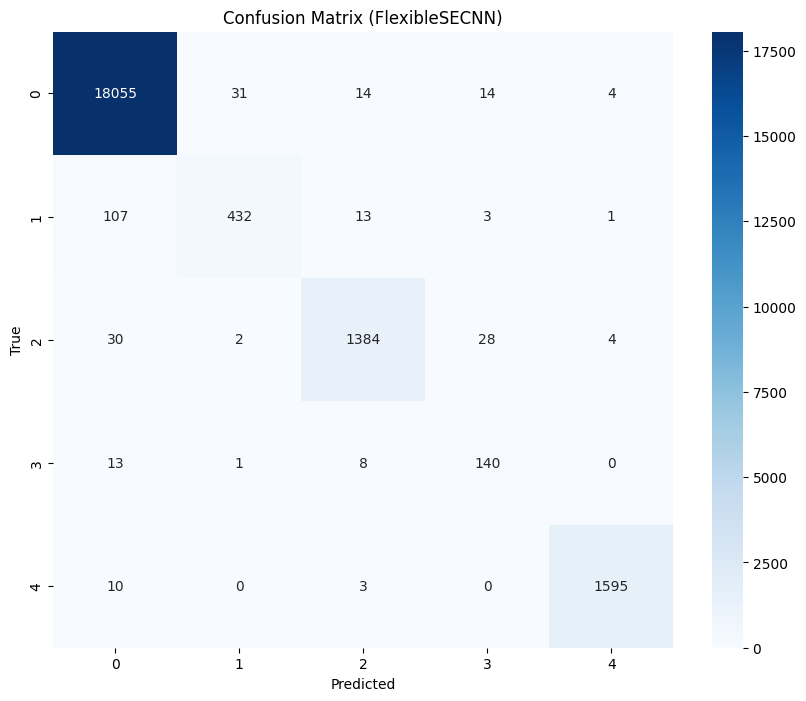

In [ ]:
# Yet to tune

best_params = {
    'num_filters': 128,
    'kernel_size': 5,
    'num_res_blocks': 5,
    'pool_size': 3,
    'pool_stride': 2,
    'dropout_rate': 0.2,
    'fc_neurons': 32,
    'learning_rate': 0.0005,
    'batch_size': 64,
    'weight_decay': 1e-5
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_length = X_train.shape[1]
num_classes = len(np.unique(y_train))

se_model = FlexibleSECNN(
    input_channels=1,
    num_classes=num_classes,
    num_filters=best_params['num_filters'],
    kernel_size=best_params['kernel_size'],
    num_res_blocks=best_params['num_res_blocks'],
    pool_size=best_params['pool_size'],
    pool_stride=best_params['pool_stride'],
    fc_neurons=best_params['fc_neurons'],
    dropout_rate=best_params['dropout_rate'],
    sequence_length=sequence_length,
    constant_filters=True,
    se_reduction=16  # SE reduction ratio
)

print(f"Model created: FlexibleSECNN")
se_model.count_parameters()

from torch.utils.data import DataLoader

train_loader = DataLoader(
    ECGDataset(X_train, y_train),
    batch_size=best_params['batch_size'],
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    ECGDataset(X_val, y_val),
    batch_size=best_params['batch_size'],
    num_workers=0
)

test_loader = DataLoader(
    ECGDataset(X_test, y_test),
    batch_size=best_params['batch_size'],
    num_workers=0
)

config = {
    'initial_lr': best_params['learning_rate'],
    'max_lr': best_params['learning_rate'] * 2,
    'warmup_epochs': 5,
    'num_epochs': 50,
    'weight_decay': best_params['weight_decay']
}

criterion = nn.CrossEntropyLoss()

# Train
trainer = ModelTrainer(
    model=se_model,
    model_name='FlexibleSECNN',
    device=device,
    criterion=criterion,
    config=config,
    early_stopping_patience=10
)

trainer.train(train_loader, val_loader, num_epochs=config['num_epochs'])
trainer.plot_training_history()
trainer.evaluate(test_loader)

 ## Data Augmented Versions

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime
import optuna
import copy
import numpy as np
import torch
from optuna.exceptions import TrialPruned
from imblearn.over_sampling import SMOTE
from tsaug import TimeWarp, Drift, AddNoise

c:\Users\zheng\OneDrive\Desktop\sc4001\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random

seed = 42

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [3]:
class ECGDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'data/mitbih_train.csv'
mitbih_test_path = 'data/mitbih_test.csv'

## Data Preprocessing: Hybrid sampling strategy 
## (Under-sampling + SMOTE Over-sampling)

In [5]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

class NewECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train, X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name}:")
        classes = np.unique(y)
        for class_id in sorted(classes):
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"  Class {int(class_id)}: {count:6d} samples ({percentage:5.2f}%)")
        print(f"  Total: {len(y)} samples")

    def preprocess_mitbih_data(self):
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        # Split before applying sampling methods
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42,
            stratify=y_train
        )

        # Print Initial class distributions
        self._print_class_distribution("INITIAL Training Set ", y_train)
        self._print_class_distribution("Validation Set", y_val)
        self._print_class_distribution("Test Set", y_test)

        # Step 1: Undersample Class 0 first
        undersample_strategy = {
            0: 40000  # Reduce Class 0 only
        }
        
        rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)
        
        # Step 2: Oversample minority classes with SMOTE
        oversample_strategy = {
            1: 15000,  
            2: 8000,    
            3: 12000,   
            4: 10000    
        }
        
        smote = SMOTE(sampling_strategy=oversample_strategy, random_state=42, k_neighbors=5)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Print final class distributions
        self._print_class_distribution("Training Set (after SMOTE + undersampling)", y_train)
        self._print_class_distribution("Validation Set", y_val)
        self._print_class_distribution("Test Set", y_test)

        # Reshape
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        print(f"\nFinal dataset sizes:")
        print(f"Training set: {X_train.shape}")
        print(f"Validation set: {X_val.shape}")
        print(f"Test set: {X_test.shape}")

        return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
# Create processor instance
processor = NewECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

Loading MIT-BIH dataset...

Class distribution in INITIAL Training Set :
  Class 0:  65223 samples (82.77%)
  Class 1:   2001 samples ( 2.54%)
  Class 2:   5209 samples ( 6.61%)
  Class 3:    577 samples ( 0.73%)
  Class 4:   5788 samples ( 7.35%)
  Total: 78798 samples

Class distribution in Validation Set:
  Class 0:   7248 samples (82.78%)
  Class 1:    222 samples ( 2.54%)
  Class 2:    579 samples ( 6.61%)
  Class 3:     64 samples ( 0.73%)
  Class 4:    643 samples ( 7.34%)
  Total: 8756 samples

Class distribution in Test Set:
  Class 0:  18118 samples (82.76%)
  Class 1:    556 samples ( 2.54%)
  Class 2:   1448 samples ( 6.61%)
  Class 3:    162 samples ( 0.74%)
  Class 4:   1608 samples ( 7.35%)
  Total: 21892 samples

Class distribution in Training Set (after SMOTE + undersampling):
  Class 0:  40000 samples (47.06%)
  Class 1:  15000 samples (17.65%)
  Class 2:   8000 samples ( 9.41%)
  Class 3:  12000 samples (14.12%)
  Class 4:  10000 samples (11.76%)
  Total: 85000 sampl

In [7]:
print("Final dataset shape:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Final dataset shape:
Training set: (85000, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


## Data Augmentation

To improve model robustness and generalization, we applied the following augmentation techniques using the `tsaug` library:

### Methods Applied

1. **Additive Gaussian Noise**
   - Simulates electronic and thermal interference in ECG equipment
   - Noise scale: 0.01
   - Probability: 60%

2. **Baseline Wander (Drift)**
   - Models low-frequency drift caused by patient respiration and movement
   - Maximum drift: 0.15
   - Drift points: 5
   - Probability: 50%

3. **Time Warping**
   - Simulates natural variations in heart rate and recording speed
   - Speed changes: 3
   - Maximum speed ratio: 1.5
   - Probability: 30%


1. Additive Noise (Gaussian):
    Applied: (85000, 187, 1)

2. Baseline Wander( Drift):
    Applied: (85000, 187, 1)

3. Time Warping:
    Applied: (85000, 187, 1)

4. Combined (Additive Noise + Baseline Wander + Time Warping) :
    Applied: (85000, 187, 1)

1. Plotting Additive Noise...


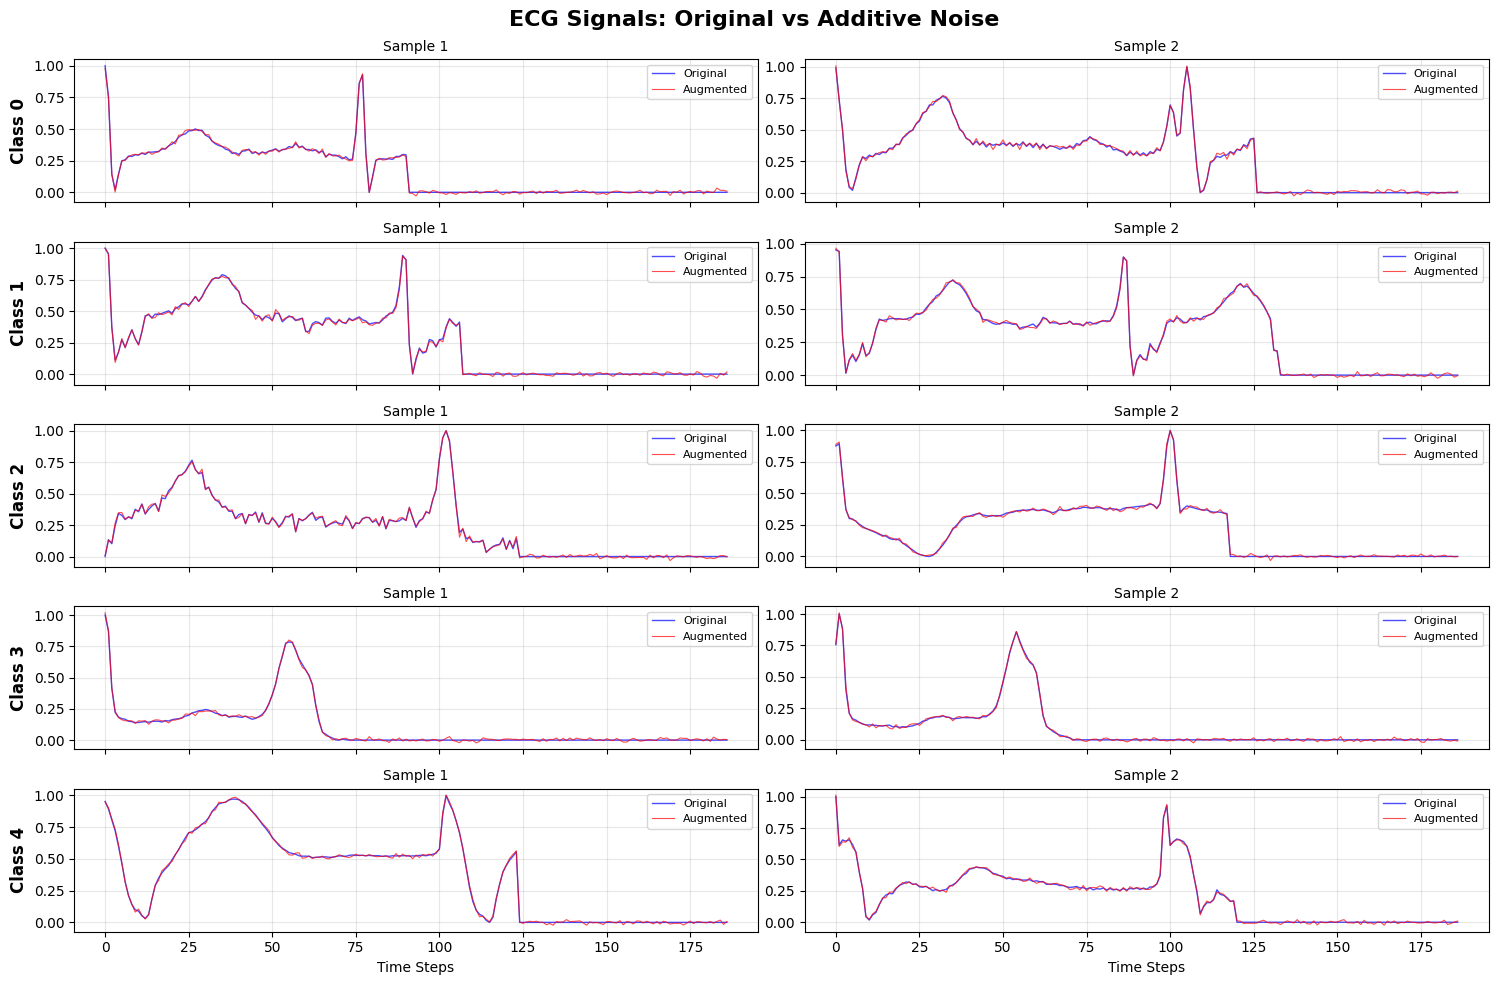


2. Plotting Baseline Wander...


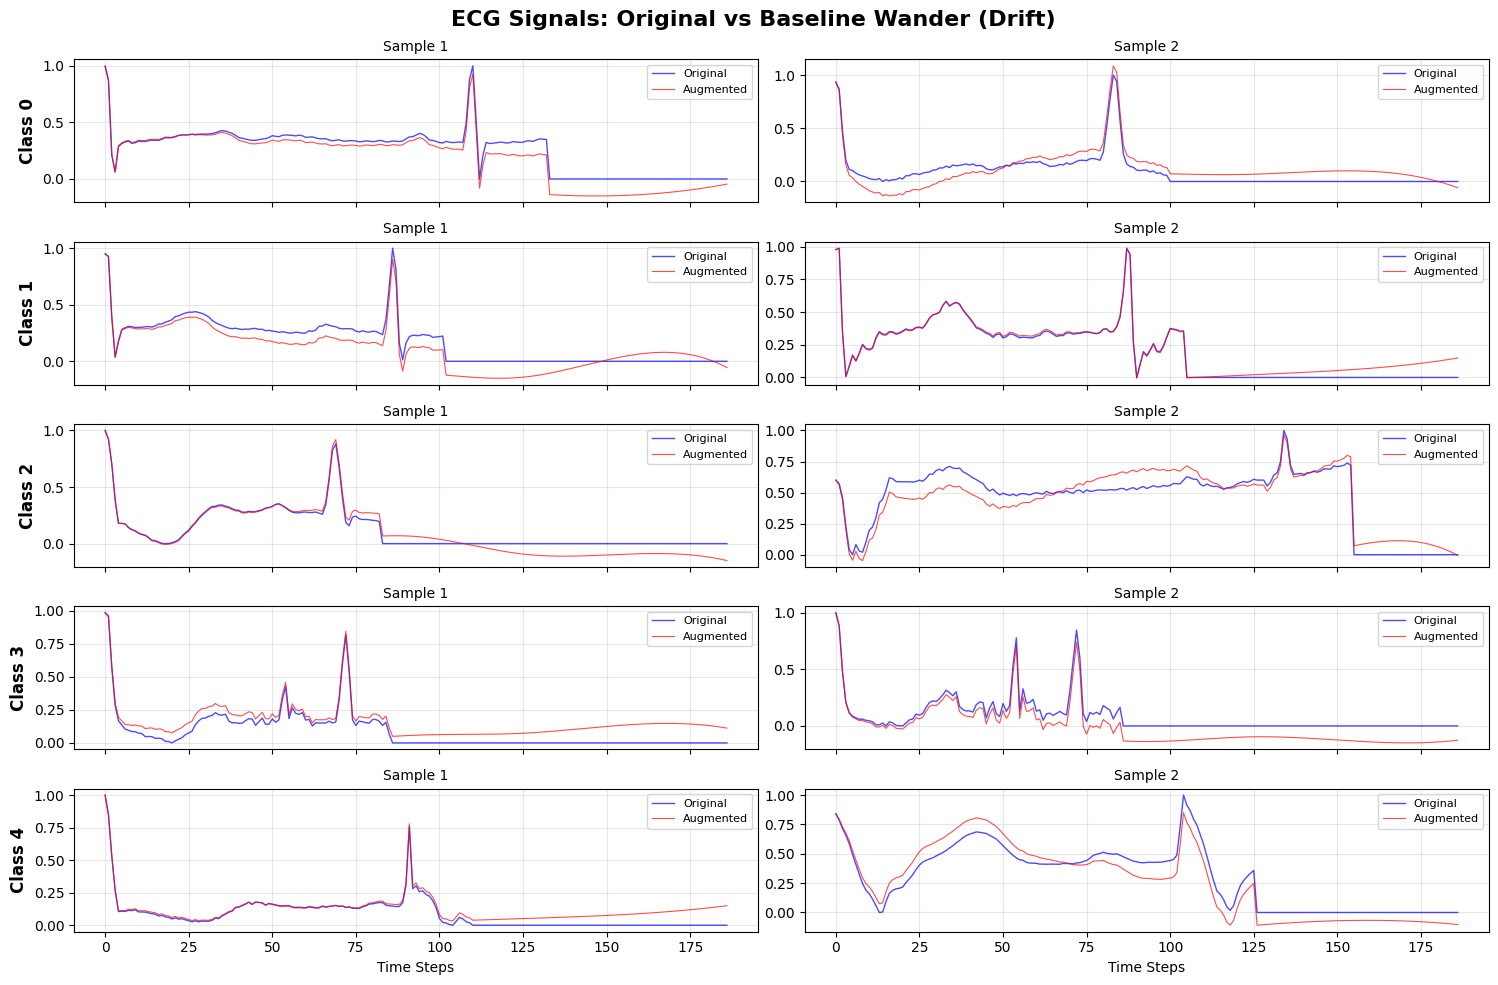


3. Plotting Time Warping...


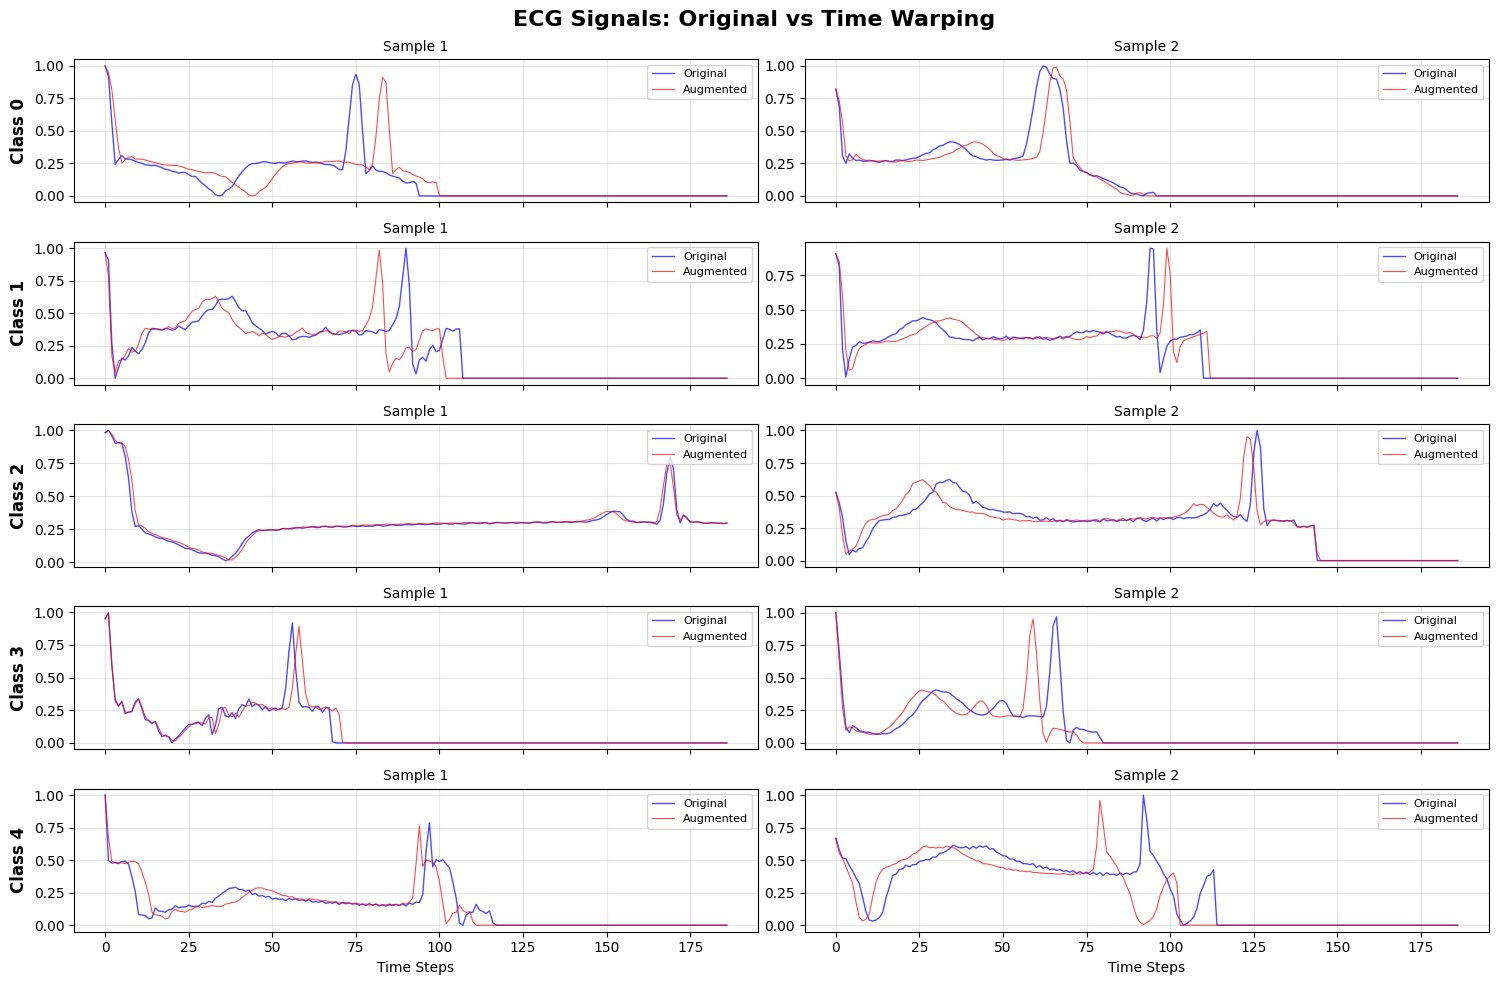


4. Plotting Combined Augmentation...


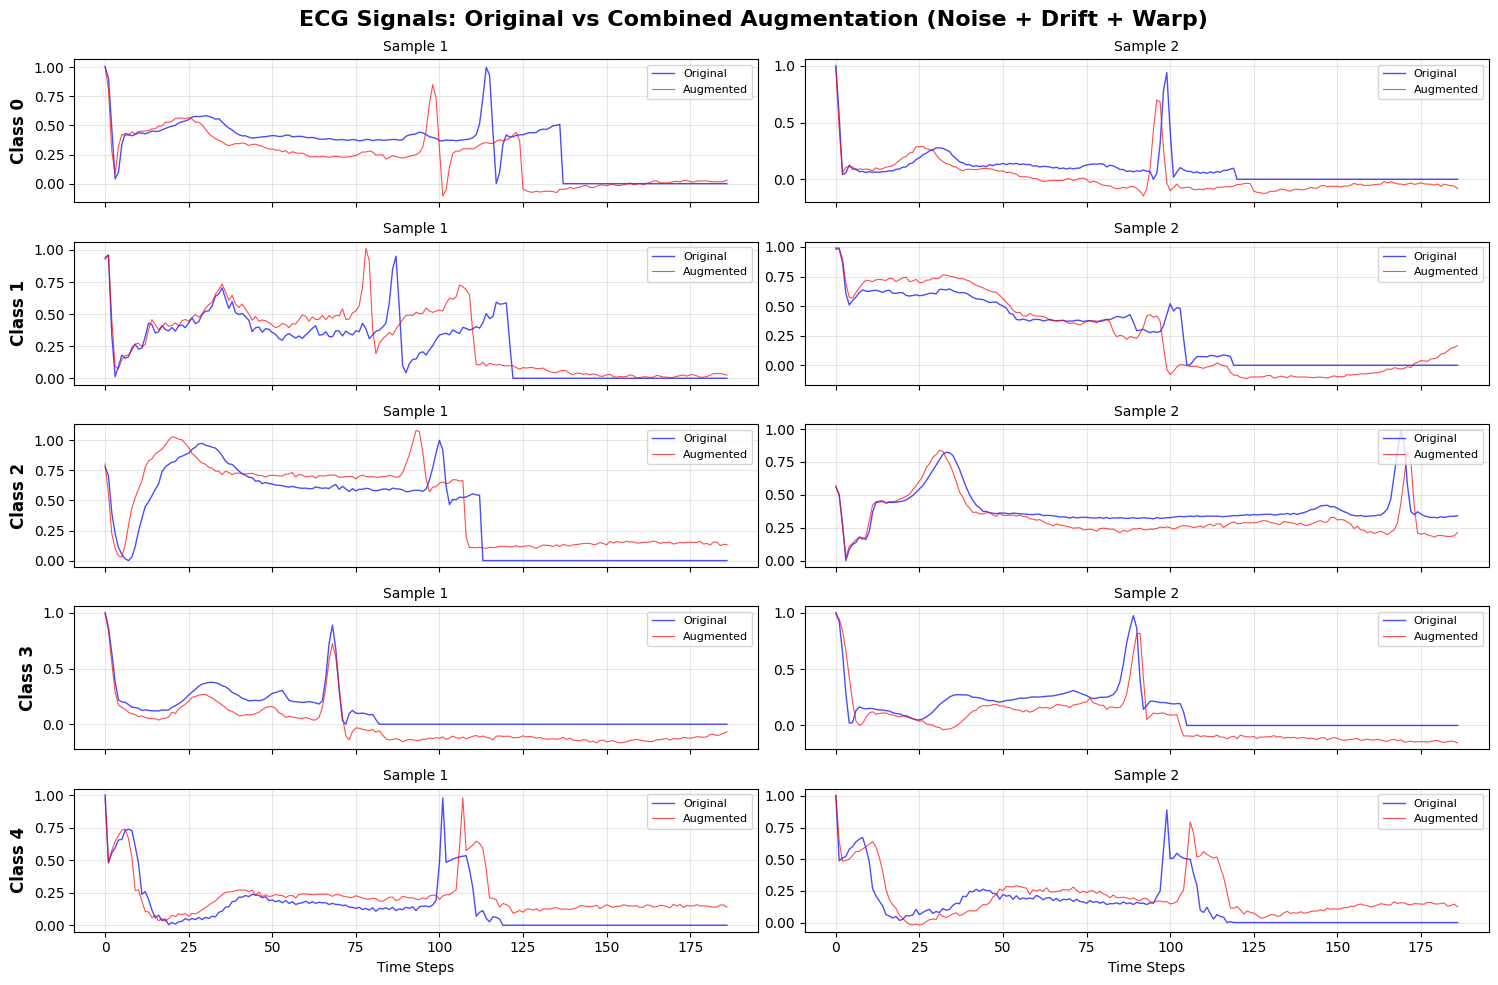

In [8]:
from tsaug import AddNoise, Drift, TimeWarp
import numpy as np
import matplotlib.pyplot as plt

# Define all augmentation methods
def apply_augmentations_separately(X_train):
    
    augmentations = {}
    
    # Additive Noise
    print("\n1. Additive Noise (Gaussian):")
    noise_augmenter = AddNoise(scale=0.01)
    augmentations['noise'] = noise_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['noise'].shape}")
    
    # Baseline Wander (Drift)
    print("\n2. Baseline Wander( Drift):")
    drift_augmenter = Drift(max_drift=0.15, n_drift_points=5)
    augmentations['drift'] = drift_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['drift'].shape}")
    
    # Time Warping
    print("\n3. Time Warping:")
    warp_augmenter = TimeWarp(n_speed_change=3, max_speed_ratio=1.5)
    augmentations['warp'] = warp_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['warp'].shape}")
    
    # Combined
    print("\n4. Combined (Additive Noise + Baseline Wander + Time Warping) :")
    combined_augmenter = (
        AddNoise(scale=0.01) +
        Drift(max_drift=0.15, n_drift_points=5) +
        TimeWarp(n_speed_change=3, max_speed_ratio=1.5)
    )
    augmentations['combined'] = combined_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['combined'].shape}")
    
    return augmentations


def plot_overlay_noise_comparison(X_original, X_noisy, y, samples_per_class=2, figsize=(15, 10), figtitle=""):
    """
    Plot original vs augmented signals overlaid
    """
    classes = np.unique(y)
    n_classes = len(classes)
    
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=figsize)
    
    # Set title
    if figtitle:
        fig.suptitle(figtitle, fontsize=16, fontweight='bold')
    else:
        fig.suptitle('ECG Signals: Original (Blue) vs Augmented (Red)', fontsize=16, fontweight='bold')
    
    # Handle single row or column
    if n_classes == 1 and samples_per_class == 1:
        axes = np.array([[axes]])
    elif n_classes == 1:
        axes = axes.reshape(1, -1)
    elif samples_per_class == 1:
        axes = axes.reshape(-1, 1)
    
    for i, class_id in enumerate(classes):
        # Get indices for this class
        class_indices = np.where(y == class_id)[0]
        
        # Randomly select samples
        selected_indices = np.random.choice(class_indices, 
                                           size=min(samples_per_class, len(class_indices)), 
                                           replace=False)
        
        for j, idx in enumerate(selected_indices):
            ax = axes[i, j] if n_classes > 1 else axes[j]
            
            # Plot both signals overlaid
            signal_original = X_original[idx].squeeze()
            signal_noisy = X_noisy[idx].squeeze()
            
            ax.plot(signal_original, linewidth=1.0, color='blue', label='Original', alpha=0.7)
            ax.plot(signal_noisy, linewidth=0.8, color='red', label='Augmented', alpha=0.7)
            
            # Add class label on the left
            if j == 0:
                ax.set_ylabel(f'Class {int(class_id)}', fontsize=12, fontweight='bold')
            
            ax.set_title(f'Sample {j+1}', fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right', fontsize=8)
            
            # Remove x-axis labels except for bottom row
            if i < n_classes - 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Time Steps', fontsize=10)
    
    plt.tight_layout()
    plt.show()


augmentations = apply_augmentations_separately(X_train)

# 1. Additive Noise
print("\n1. Plotting Additive Noise...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['noise'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Additive Noise'
)

# 2. Baseline Wander
print("\n2. Plotting Baseline Wander...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['drift'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Baseline Wander (Drift)'
)

# 3. Time Warping
print("\n3. Plotting Time Warping...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['warp'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Time Warping'
)

# 4. Combined
print("\n4. Plotting Combined Augmentation...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['combined'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Combined Augmentation (Noise + Drift + Warp)'
)

In [ ]:
# Added new class for augmented datasets and dataloaders

class ECGDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ECGDatasetAugmented(Dataset):
    """
    Custom Dataset class for ECG data with optional augmentation
    """
    def __init__(self, X, y, augment=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.augment = augment
        
        if self.augment:
            self.augmenter = (
                AddNoise(scale=0.01) @ 0.6 +  # 60% probability
                Drift(max_drift=0.15, n_drift_points=5) @ 0.5 +  # 50% probability
                TimeWarp(n_speed_change=3, max_speed_ratio=1.5) @ 0.3  # 30% probability
            )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.augment:
            x_numpy = x.numpy()
            x_aug = self.augmenter.augment(x_numpy.squeeze())
            x = torch.FloatTensor(x_aug.reshape(x_numpy.shape))
        
        return x, y


def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32, augment_train=True):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets - only augment training set
    train_dataset = ECGDatasetAugmented(X_train, y_train, augment=augment_train)
    val_dataset = ECGDatasetAugmented(X_val, y_val, augment=False)
    test_dataset = ECGDatasetAugmented(X_test, y_test, augment=False)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Print class distributions
    print("\n" + "="*60)
    print("DATA LOADERS CREATED")
    print("="*60)
    
    print(f"\nDataLoader Information:")
    print(f"  Training batches: {len(train_loader)} (batch_size={batch_size}, augment={augment_train})")
    print(f"  Validation batches: {len(val_loader)} (batch_size={batch_size})")
    print(f"  Test batches: {len(test_loader)} (batch_size={batch_size})")

    return train_loader, val_loader, test_loader


# Create data loaders WITH augmentation
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test, 
    batch_size=32, 
    augment_train=True 
)

# Print final dataset sizes
print("\n" + "="*60)
print("FINAL DATASET SHAPES")
print("="*60)
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


DATA LOADERS CREATED

DataLoader Information:
  Training batches: 2657 (batch_size=32, augment=True)
  Validation batches: 274 (batch_size=32)
  Test batches: 685 (batch_size=32)

FINAL DATASET SHAPES
Training set: (85000, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [10]:
# Verify augmentation is actually happening
print("\n" + "="*60)
print("VERIFYING DYNAMIC AUGMENTATION")
print("="*60)

# Check the dataset class being used
print(f"Training dataset class: {type(train_loader.dataset).__name__}")
print(f"Augmentation enabled: {train_loader.dataset.augment}")

# Get two batches and see if they're different (proof of dynamic augmentation)
train_iter = iter(train_loader)
batch1_X, _ = next(train_iter)
batch1_X_first_sample = batch1_X[0].numpy()

# Reset and get same batch again (will be different due to dynamic augmentation)
train_iter = iter(train_loader)
batch2_X, _ = next(train_iter)
batch2_X_first_sample = batch2_X[0].numpy()

# They should be different due to augmentation
difference = np.abs(batch1_X_first_sample - batch2_X_first_sample).mean()
print(f"\nDifference between two fetches of same sample: {difference:.6f}")
if difference > 0:
    print(" Dynamic augmentation is WORKING (samples are different)")
else:
    print(" No augmentation (samples are identical)")


VERIFYING DYNAMIC AUGMENTATION
Training dataset class: ECGDatasetAugmented
Augmentation enabled: True

Difference between two fetches of same sample: 0.164289
 Dynamic augmentation is WORKING (samples are different)


Model created: FlexibleSECNN

Model Parameters:
Total parameters: 769,893
Trainable parameters: 769,893

Starting training for FlexibleSECNN...
Early stopping enabled with patience=10


Training: 100%|██████████| 1329/1329 [01:50<00:00, 11.99it/s]



Epoch [1/50]
Train Loss: 1.2426, Train Acc: 55.35%
Val Loss: 0.3844, Val Acc: 82.64%
Learning Rate: 0.000600
✓ New best model saved! (Val Loss: 0.3844)
Validation loss improved to 0.3844


Training: 100%|██████████| 1329/1329 [01:49<00:00, 12.15it/s]



Epoch [2/50]
Train Loss: 0.6139, Train Acc: 76.18%
Val Loss: 0.2742, Val Acc: 87.48%
Learning Rate: 0.000700
✓ New best model saved! (Val Loss: 0.2742)
Validation loss improved to 0.2742


Training: 100%|██████████| 1329/1329 [01:50<00:00, 12.00it/s]



Epoch [3/50]
Train Loss: 0.3989, Train Acc: 85.57%
Val Loss: 0.1257, Val Acc: 97.19%
Learning Rate: 0.000800
✓ New best model saved! (Val Loss: 0.1257)
Validation loss improved to 0.1257


Training: 100%|██████████| 1329/1329 [01:48<00:00, 12.20it/s]



Epoch [4/50]
Train Loss: 0.2464, Train Acc: 93.16%
Val Loss: 0.1672, Val Acc: 95.98%
Learning Rate: 0.000900
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1329/1329 [01:50<00:00, 12.03it/s]



Epoch [5/50]
Train Loss: 0.1736, Train Acc: 95.36%
Val Loss: 0.1175, Val Acc: 96.95%
Learning Rate: 0.001000
✓ New best model saved! (Val Loss: 0.1175)
Validation loss improved to 0.1175


Training: 100%|██████████| 1329/1329 [01:59<00:00, 11.15it/s]



Epoch [6/50]
Train Loss: 0.1372, Train Acc: 96.30%
Val Loss: 0.0833, Val Acc: 98.05%
Learning Rate: 0.000999
✓ New best model saved! (Val Loss: 0.0833)
Validation loss improved to 0.0833


Training: 100%|██████████| 1329/1329 [02:00<00:00, 11.07it/s]



Epoch [7/50]
Train Loss: 0.1057, Train Acc: 97.18%
Val Loss: 0.0909, Val Acc: 98.02%
Learning Rate: 0.000998
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1329/1329 [01:50<00:00, 12.06it/s]



Epoch [8/50]
Train Loss: 0.0872, Train Acc: 97.74%
Val Loss: 0.0829, Val Acc: 97.74%
Learning Rate: 0.000995
✓ New best model saved! (Val Loss: 0.0829)
Validation loss improved to 0.0829


Training: 100%|██████████| 1329/1329 [01:50<00:00, 12.07it/s]



Epoch [9/50]
Train Loss: 0.0722, Train Acc: 98.13%
Val Loss: 0.0779, Val Acc: 98.40%
Learning Rate: 0.000990
✓ New best model saved! (Val Loss: 0.0779)
Validation loss improved to 0.0779


Training: 100%|██████████| 1329/1329 [01:50<00:00, 12.05it/s]



Epoch [10/50]
Train Loss: 0.0586, Train Acc: 98.47%
Val Loss: 0.0606, Val Acc: 98.48%
Learning Rate: 0.000985
✓ New best model saved! (Val Loss: 0.0606)
Validation loss improved to 0.0606


Training: 100%|██████████| 1329/1329 [01:52<00:00, 11.83it/s]



Epoch [11/50]
Train Loss: 0.0505, Train Acc: 98.72%
Val Loss: 0.0805, Val Acc: 98.52%
Learning Rate: 0.000978
EarlyStopping counter: 1 out of 10


Training: 100%|██████████| 1329/1329 [01:49<00:00, 12.14it/s]



Epoch [12/50]
Train Loss: 0.0449, Train Acc: 98.91%
Val Loss: 0.0859, Val Acc: 98.61%
Learning Rate: 0.000971
EarlyStopping counter: 2 out of 10


Training: 100%|██████████| 1329/1329 [01:50<00:00, 12.02it/s]



Epoch [13/50]
Train Loss: 0.0393, Train Acc: 98.98%
Val Loss: 0.0655, Val Acc: 98.60%
Learning Rate: 0.000962
EarlyStopping counter: 3 out of 10


Training: 100%|██████████| 1329/1329 [01:56<00:00, 11.43it/s]



Epoch [14/50]
Train Loss: 0.0351, Train Acc: 99.10%
Val Loss: 0.0888, Val Acc: 98.42%
Learning Rate: 0.000952
EarlyStopping counter: 4 out of 10


Training: 100%|██████████| 1329/1329 [01:55<00:00, 11.53it/s]



Epoch [15/50]
Train Loss: 0.0327, Train Acc: 99.19%
Val Loss: 0.0703, Val Acc: 98.68%
Learning Rate: 0.000942
EarlyStopping counter: 5 out of 10


Training: 100%|██████████| 1329/1329 [01:57<00:00, 11.27it/s]



Epoch [16/50]
Train Loss: 0.0277, Train Acc: 99.27%
Val Loss: 0.0770, Val Acc: 98.55%
Learning Rate: 0.000930
EarlyStopping counter: 6 out of 10


Training: 100%|██████████| 1329/1329 [01:58<00:00, 11.20it/s]



Epoch [17/50]
Train Loss: 0.0254, Train Acc: 99.35%
Val Loss: 0.0853, Val Acc: 98.54%
Learning Rate: 0.000917
EarlyStopping counter: 7 out of 10


Training: 100%|██████████| 1329/1329 [01:58<00:00, 11.24it/s]



Epoch [18/50]
Train Loss: 0.0258, Train Acc: 99.34%
Val Loss: 0.0712, Val Acc: 98.69%
Learning Rate: 0.000904
EarlyStopping counter: 8 out of 10


Training: 100%|██████████| 1329/1329 [01:56<00:00, 11.42it/s]



Epoch [19/50]
Train Loss: 0.0193, Train Acc: 99.47%
Val Loss: 0.0890, Val Acc: 98.71%
Learning Rate: 0.000890
EarlyStopping counter: 9 out of 10


Training: 100%|██████████| 1329/1329 [01:51<00:00, 11.90it/s]



Epoch [20/50]
Train Loss: 0.0207, Train Acc: 99.54%
Val Loss: 0.0787, Val Acc: 98.90%
Learning Rate: 0.000875
EarlyStopping counter: 10 out of 10

Early stopping triggered! No improvement for 10 epochs.
Best validation loss: 0.0606 at epoch 10

Training stopped early at epoch 20
Best validation loss: 0.0606
Best epoch: 10


Training Summary for FlexibleSECNN
Total epochs trained: 20
Best validation loss: 0.0606
Final train accuracy: 99.54%
Final validation accuracy: 98.90%



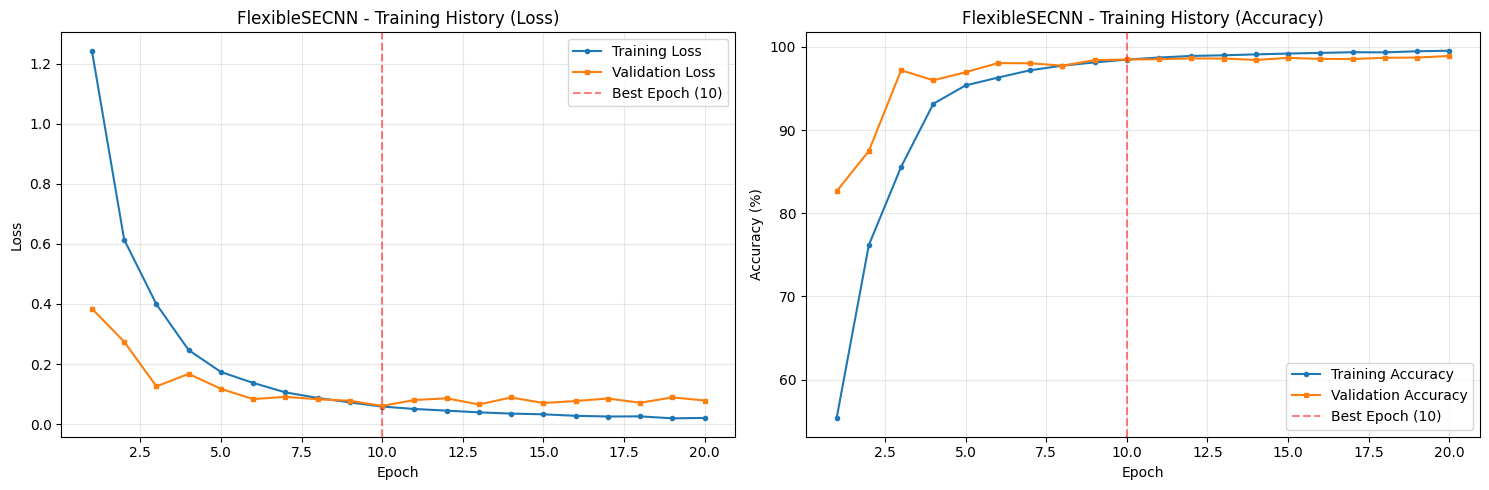

Testing: 100%|██████████| 343/343 [00:07<00:00, 44.14it/s]



Classification Report (FlexibleSECNN):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.86      0.85      0.85       556
           2       0.98      0.95      0.96      1448
           3       0.80      0.86      0.83       162
           4       1.00      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.92      0.93      0.93     21892
weighted avg       0.99      0.99      0.99     21892



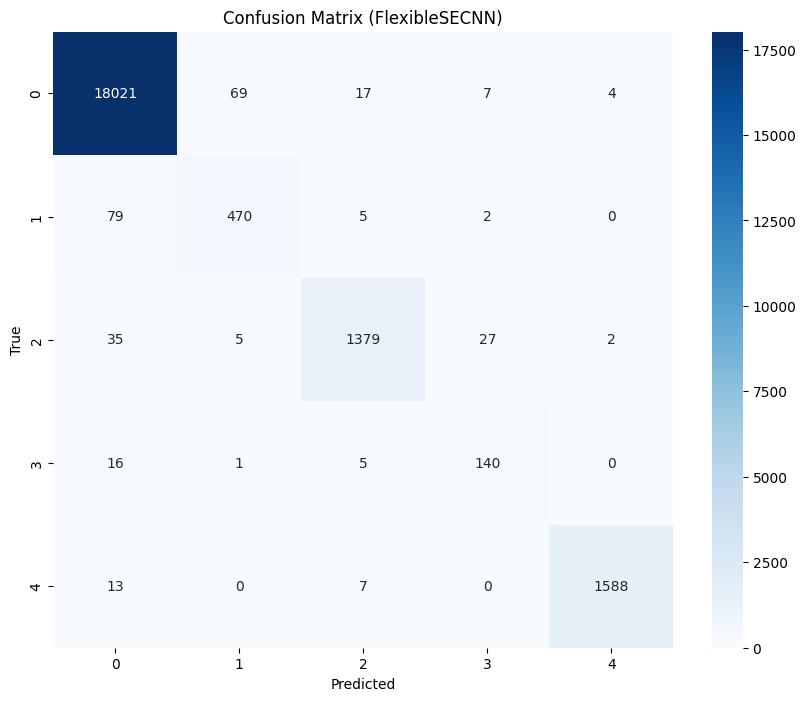

In [18]:
# Yet to tune

best_params = {
    'num_filters': 128,
    'kernel_size': 5,
    'num_res_blocks': 5,
    'pool_size': 3,
    'pool_stride': 2,
    'dropout_rate': 0.2,
    'fc_neurons': 32,
    'learning_rate': 0.0005,
    'batch_size': 64,
    'weight_decay': 1e-5
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_length = X_train.shape[1]
num_classes = len(np.unique(y_train))

se_model = FlexibleSECNN(
    input_channels=1,
    num_classes=num_classes,
    num_filters=best_params['num_filters'],
    kernel_size=best_params['kernel_size'],
    num_res_blocks=best_params['num_res_blocks'],
    pool_size=best_params['pool_size'],
    pool_stride=best_params['pool_stride'],
    fc_neurons=best_params['fc_neurons'],
    dropout_rate=best_params['dropout_rate'],
    sequence_length=sequence_length,
    constant_filters=True,
    se_reduction=16  # SE reduction ratio
)

print(f"Model created: FlexibleSECNN")
se_model.count_parameters()

from torch.utils.data import DataLoader

train_loader = DataLoader(
    ECGDataset(X_train, y_train),
    batch_size=best_params['batch_size'],
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    ECGDataset(X_val, y_val),
    batch_size=best_params['batch_size'],
    num_workers=0
)

test_loader = DataLoader(
    ECGDataset(X_test, y_test),
    batch_size=best_params['batch_size'],
    num_workers=0
)

config = {
    'initial_lr': best_params['learning_rate'],
    'max_lr': best_params['learning_rate'] * 2,
    'warmup_epochs': 5,
    'num_epochs': 50,
    'weight_decay': best_params['weight_decay']
}

criterion = nn.CrossEntropyLoss()

# Train
trainer = ModelTrainer(
    model=se_model,
    model_name='FlexibleSECNN',
    device=device,
    criterion=criterion,
    config=config,
    early_stopping_patience=10
)

trainer.train(train_loader, val_loader, num_epochs=config['num_epochs'])
trainer.plot_training_history()
trainer.evaluate(test_loader)